## Install libraries.

In [ ]:
# Installing eagleSqlTools
!pip install eagleSqlTools

# Bachellor Thesis

Selec disc galaxies with stellar mass from $1\cdot{}10^9 M_\odot$ and above. Use the high resolution simulation RecalL0025N0752.

To detect that galaxies have spirals we will study the gas spin-

## Libraries and conection

In [ ]:
import eagleSqlTools as eagle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtb

In [ ]:
# connection with the database:
Juanjo = {'username':'<username>', 'password': '<password>'}
con = eagle.connect(user= Juanjo['username'], password= Juanjo['password'])

## Query Data

### Query Data 0
The Sub_Halo table allows to obtain the main parameters.

In [ ]:
Query = "SELECT \
                SH.GalaxyID, \
                SH.Mass, \
                SH.Vmax as v_max \
          FROM \
                RefL0050N0752_SubHalo AS SH \
          WHERE \
                SH.MassType_Star >= 1E09 AND \
                SH.SubGroupNumber = 0 AND \
                SH.SnapNum = 28 \
          ORDER BY \
                SH.GalaxyID"

Data = eagle.execute_query(con , Query)
np.shape(Data)

(990,)

### Query Data 1
The same table but now using MassType_Star (Total stellar mass) as condicition rather than Mass (Total mass).

In [ ]:
Query_1 = "SELECT \
                SH.GalaxyID, \
                SH.MassType_Star, \
                SH.MassType_Gas, \
                SH.Vmax \
          FROM \
                RefL0050N0752_SubHalo AS SH \
          WHERE \
                SH.MassType_Star >= 1E09 AND \
                SH.SubGroupNumber = 0 AND \
                SH.SnapNum = 28 \
          ORDER BY \
                SH.GalaxyID"


Data_1 = eagle.execute_query(con , Query_1)
np.shape(Data_1)

(990,)

### Querry Data 2
The MorphoKinem table allows to obtain interesting parameters $(\epsilon, T)$ to be able to study the morphologies of the galaxies but it does not allow the study of all of them.

Whereby: 

$$ \epsilon = 1 - \frac{c}{a} \in [0,1]$$
$$ T = \frac{a^2 - b^2}{a^2 - c^2} \in [0,1] $$

where a, b and c are the module of halos' axes, from major to minor.

The Rotational kinetic energy $(k_{rot})$ is other parameter that it could be obtained in the MorphoKinem table, it is Stellar counter-rotating kinetic enegy fraction 

In [ ]:
Query_2 = "SELECT \
                MK.GalaxyID, \
                MK.Ellipticity AS epsilon , \
                MK.Triaxiality AS T, \
                MK.KappaCoRot \
          FROM \
                RefL0050N0752_SubHalo AS SH, \
                RefL0050N0752_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E09 AND \
                SH.SubGroupNumber = 0 AND \
                SH.SnapNum = 28 \
          ORDER BY \
                SH.GalaxyID"

Data_2 = eagle.execute_query(con , Query_2)
np.shape(Data_2)

(990,)

### Querry Data 3
The Magnitudes table allows use the absolute magnitudes filters.

In [ ]:
Query_3 = "SELECT \
                MG.GalaxyID, \
                MG.u_nodust AS u_filter, \
                MG.r_nodust AS r_filter \
          FROM \
                RefL0050N0752_SubHalo AS SH, \
                RefL0050N0752_Magnitudes AS MG \
          WHERE \
                SH.GalaxyID = MG.GalaxyID AND \
                SH.MassType_Star >= 1E09 AND \
                SH.SubGroupNumber = 0 AND \
                SH.SnapNum = 28 \
          ORDER BY \
                SH.GalaxyID"

Data_3 = eagle.execute_query(con , Query_3)
np.shape(Data_3)

(990,)

### Galaxy imageLinks Generator (GalaxyImgLinks).

In [ ]:
def GalaxyImgLinks(ID, Database = 'RefL0050N0752_SubHalo', SnapNum=28):
  query = "SELECT \
              Image_face, \
              Image_edge, \
              Image_box \
           FROM \
              %s \
           WHERE \
              SnapNum = %s \
              and GalaxyID = %s"%(Database, SnapNum, ID)

  return eagle.execute_query(con, query)

# Example:
GalaxyImgLinks(1479010)

array((b"<img src='http://virgodb.cosma.dur.ac.uk/eagle-webstorage/RefL0050N0752_Subhalo/galface_1479010.png'>", b"<img src='http://virgodb.cosma.dur.ac.uk/eagle-webstorage/RefL0050N0752_Subhalo/galedge_1479010.png'>", b"<img src='http://virgodb.cosma.dur.ac.uk/eagle-webstorage/RefL0050N0752_Subhalo/galrand_1479010.png'>"),
      dtype=[('Image_face', 'S256'), ('Image_edge', 'S256'), ('Image_box', 'S256')])

## Data manipulation

Next, we will take a main Dataframe, called df, with the whole set of galaxies and all its information, there is some information about some specifics galaxies that it is not in the SubHalo table, so the whole information will have to unify.

In [ ]:
def add_data(to_df, from_df, colum):
  return [from_df.loc[i][colum] if i in from_df.index else np.nan for i in to_df.index]

In [ ]:
# Generatino of Dataframe
df  = pd.DataFrame(Data).set_index('GalaxyID')

df_1 = pd.DataFrame(Data_1).set_index('GalaxyID')
df_1['MassType_Bar'] = df_1['MassType_Star'] + df_1['MassType_Gas']

df_2 = pd.DataFrame(Data_2).set_index('GalaxyID')

df_3 = pd.DataFrame(Data_3).set_index('GalaxyID')
df_3['u-r'] = df_3['u_filter'] - df_3['r_filter']


# Mix of all the Dataframe
df['Mass_stars'] = add_data(df, df_1, 'MassType_Star')
df['Mass_gas']   = add_data(df, df_1, 'MassType_Gas')
df['Mass_bar']   = add_data(df, df_1, 'MassType_Bar')
df['epsilon']    = add_data(df, df_2, 'epsilon')
df['T']          = add_data(df, df_2, 'T')
df['k_rot']      = add_data(df, df_2, 'KappaCoRot')
df['u-r']        = add_data(df, df_3, 'u-r')

"""
Mass --> [Mass] = solar masses
v_max --> [v_max] = km s^-1
Mass_star --> [Mass_stars] = solar masses
Mass_gas --> [Mass_gas] = solar masses
Mass_bar --> [Mass_bar] = solar masses
epsilon --> [epsilon] = None
T --> [T] = None
k_rot --> [k_rot] = None
u-r --> [u-r] = [u] = [r] = mag
"""

df

,Mass,v_max,Mass_stars,Mass_gas,Mass_bar,epsilon,T,k_rot,u-r
GalaxyID,,,,,,,,,
165372,2.261959e+10,74.009285,1.220769e+09,0.000000e+00,1.220769e+09,0.207366,0.304865,0.271714,2.302270
580563,1.212400e+11,87.035484,1.024681e+09,3.270071e+09,4.294752e+09,0.280752,0.597823,0.172794,1.167559
593139,1.237809e+11,98.434052,2.557534e+09,4.873412e+08,3.044875e+09,0.411354,0.062803,0.388590,1.608477
599202,1.461041e+11,84.501297,1.023775e+09,0.000000e+00,1.023775e+09,0.310914,0.563807,0.208956,2.189999
599648,1.438893e+11,85.922684,1.118190e+09,4.926326e+08,1.610822e+09,0.542521,0.224507,0.345154,1.528059
...,...,...,...,...,...,...,...,...,...
2639531,1.597899e+13,387.887177,1.992180e+11,1.429076e+12,1.628294e+12,0.629499,0.738506,0.213110,2.356546
2656266,1.523952e+13,361.000916,1.983381e+11,1.489303e+12,1.687641e+12,0.479341,0.371278,0.321531,2.220762
2670481,1.730008e+14,793.984985,1.034357e+12,2.445943e+13,2.549378e+13,0.447370,0.968948,0.132092,2.355844


### Kinectic parameter $k_{rot}$

The Stellar counter-rotating kinetic enegy fraction could be use to determinant the morphology of a galaxy.   

If $k_{rot} \geq 0.4$ the galaxy could be considered with disc.

In [ ]:
df['Disc'] = df_2['KappaCoRot'] >= 0.4; df

,Mass,v_max,Mass_stars,Mass_gas,Mass_bar,epsilon,T,k_rot,u-r,Disc
GalaxyID,,,,,,,,,,
165372,2.261959e+10,74.009285,1.220769e+09,0.000000e+00,1.220769e+09,0.207366,0.304865,0.271714,2.302270,False
580563,1.212400e+11,87.035484,1.024681e+09,3.270071e+09,4.294752e+09,0.280752,0.597823,0.172794,1.167559,False
593139,1.237809e+11,98.434052,2.557534e+09,4.873412e+08,3.044875e+09,0.411354,0.062803,0.388590,1.608477,False
599202,1.461041e+11,84.501297,1.023775e+09,0.000000e+00,1.023775e+09,0.310914,0.563807,0.208956,2.189999,False
599648,1.438893e+11,85.922684,1.118190e+09,4.926326e+08,1.610822e+09,0.542521,0.224507,0.345154,1.528059,False
...,...,...,...,...,...,...,...,...,...,...
2639531,1.597899e+13,387.887177,1.992180e+11,1.429076e+12,1.628294e+12,0.629499,0.738506,0.213110,2.356546,False
2656266,1.523952e+13,361.000916,1.983381e+11,1.489303e+12,1.687641e+12,0.479341,0.371278,0.321531,2.220762,False
2670481,1.730008e+14,793.984985,1.034357e+12,2.445943e+13,2.549378e+13,0.447370,0.968948,0.132092,2.355844,False


In [ ]:
np.sum(df['Disc'])

385

## Tully–Fisher relation (TFR)

In astronomy, the Tully–Fisher relation (TFR) is an empirical relationship between the mass of a spiral galaxy and its asymptotic rotation velocity.

### Complete Tully-Fisher Relation
### Representation: $lg_{10}(v_{max})$ vs $lg_{10}(M)$

In [ ]:
x_TFR= np.log10(df['Mass'])
y_TFR= np.log10(df['v_max'])

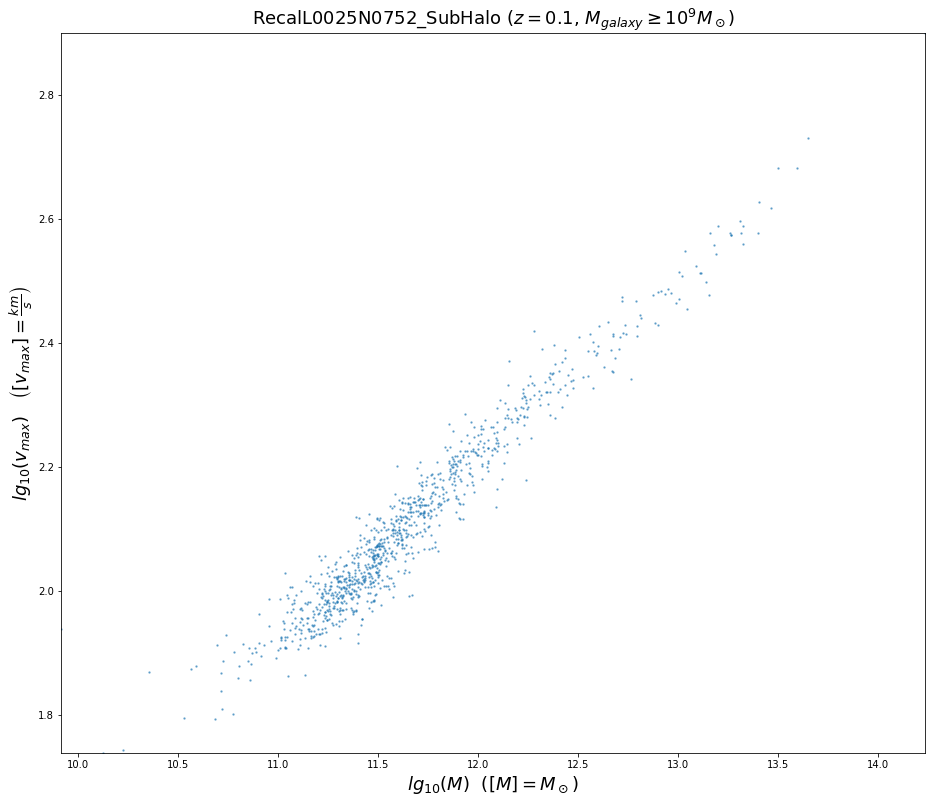

In [ ]:
# figure and axis
fig_TFR = plt.figure(figsize=(12,10))
ax_TFR = fig_TFR.add_axes([0,0,1,1])

# ax, title
ax_TFR.set_title(r'RecalL0025N0752_SubHalo $(z = 0.1$, $M_{galaxy} \geq 10^9 M_\odot)$', fontsize=18)
# Data
ax_TFR.scatter(x_TFR, y_TFR, s=2, alpha=0.50)
# Labels
ax_TFR.set_xlabel(r'$lg_{10}(M)$  $\left([M] = M_\odot\right)$', fontsize=18)
ax_TFR.set_ylabel(r'$lg_{10}(v_{max})$   $\left([v_{max}] = \frac{km}{s}\right)$', fontsize=18)
# Limits
ax_TFR.set_xlim(min(x_TFR), max(x_TFR))
ax_TFR.set_ylim(min(y_TFR), max(y_TFR))

plt.show()

### Stellar Tully–Fisher relation (STFR)
### Representation: $lg_{10}(v_{max})$ vs $lg_{10}(M_{stars})$

The same representation as before but now using only the mass of the stars of each galaxy.

In [ ]:
df_STFR= df.dropna(subset=['Mass_stars', 'v_max'])
x_STFR= np.log10(df_STFR['Mass_stars']).values
y_STFR= np.log10(df_STFR['v_max']).values

fit_STFR= np.polyfit(x_STFR, y_STFR, 1)
fit_STFR

array([ 0.2575143 , -0.40477745])

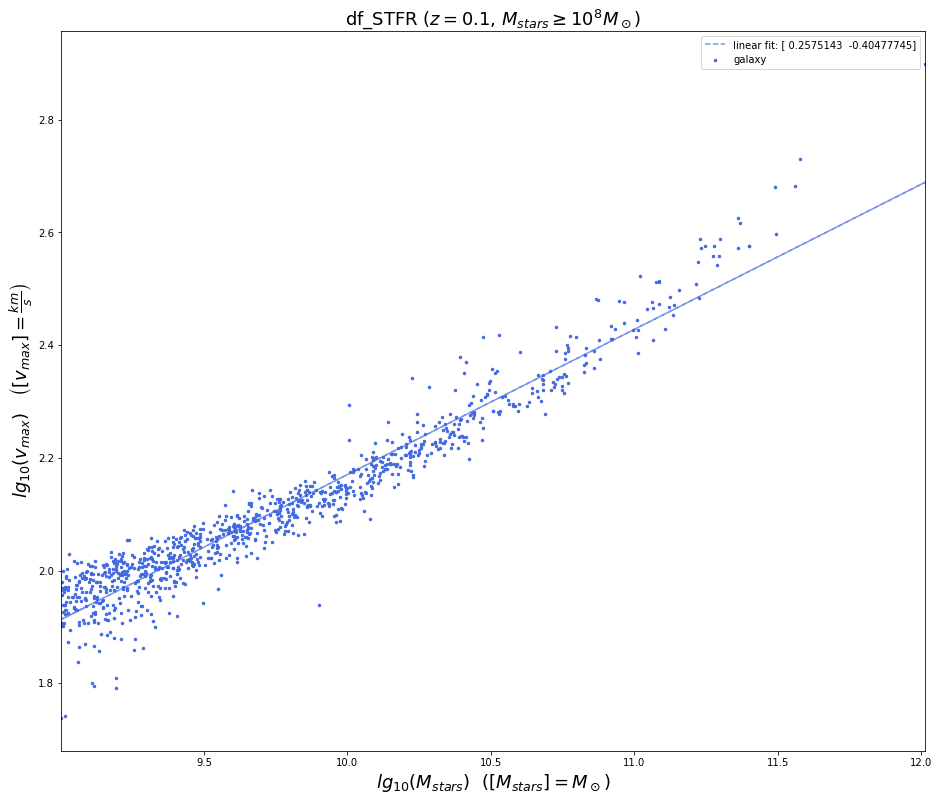

In [ ]:
# figure and axis
fig_STFR= plt.figure(figsize=(12,10))
ax_STFR= fig_STFR.add_axes([0,0,1,1])

# ax, title
ax_STFR.set_title(r'df_STFR $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_STFR.scatter(x_STFR, y_STFR, s=6, alpha=1, color='royalblue', label='galaxy')
ax_STFR.plot(x_STFR, fit_STFR[0]*x_STFR + fit_STFR[1], color='royalblue',
        linestyle='--', alpha=0.7, label="linear fit: "+str(fit_STFR))

# Labels
ax_STFR.set_xlabel(r'$lg_{10}(M_{stars})$  $\left([M_{stars}] = M_\odot\right)$', fontsize=18)
ax_STFR.set_ylabel(r'$lg_{10}(v_{max})$   $\left([v_{max}] = \frac{km}{s}\right)$', fontsize=18)
# Limits
ax_STFR.set_xlim(min(x_STFR), max(x_STFR))
# Legend
ax_STFR.legend()


plt.show()

### Barionic Tully–Fisher relation (BTFR)
### Representation: $lg_{10}(v_{max})$ vs $lg_{10}(M_{barionic})$

The same representation as before but now adding cold gas of each galaxy.

In [ ]:
df_BTFR= df.dropna(subset=['Mass_bar', 'v_max'])
x_BTFR= np.log10(df_BTFR['Mass_bar']).values
y_BTFR= np.log10(df_BTFR['v_max']).values

fit_BTFR= np.polyfit(x_BTFR, y_BTFR, 1)
fit_BTFR

array([ 0.21305187, -0.07859593])

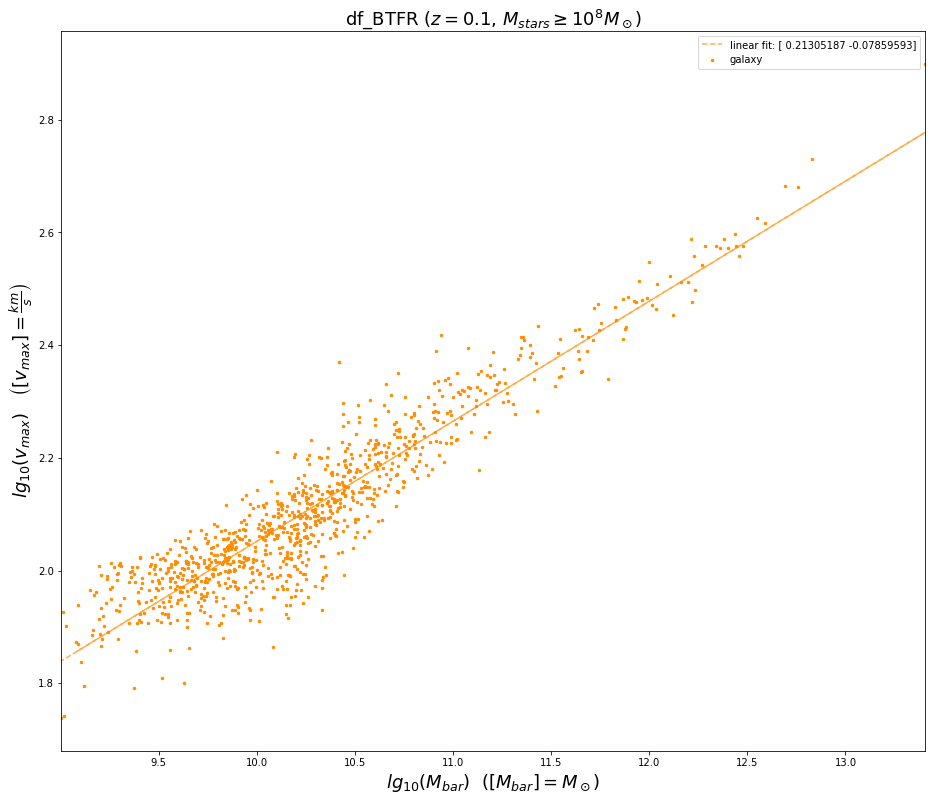

In [ ]:
# figure and axis
fig_BTFR= plt.figure(figsize=(12,10))
ax_BTFR= fig_BTFR.add_axes([0,0,1,1])

# ax, title
ax_BTFR.set_title(r'df_BTFR $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_BTFR.scatter(x_BTFR, y_BTFR, s=6, alpha=1, color='darkorange', label='galaxy')
ax_BTFR.plot(x_BTFR, fit_BTFR[0]*x_BTFR + fit_BTFR[1], color='darkorange', 
        linestyle='--', alpha=0.7, label="linear fit: "+str(fit_BTFR))

# Labels
ax_BTFR.set_xlabel(r'$lg_{10}(M_{bar})$  $\left([M_{bar}] = M_\odot\right)$', fontsize=18)
ax_BTFR.set_ylabel(r'$lg_{10}(v_{max})$   $\left([v_{max}] = \frac{km}{s}\right)$', fontsize=18)
# Limits
ax_BTFR.set_xlim(min(x_BTFR), max(x_BTFR))
# Legend
ax_BTFR.legend()


plt.show()

### Comparison STFR-BTFR

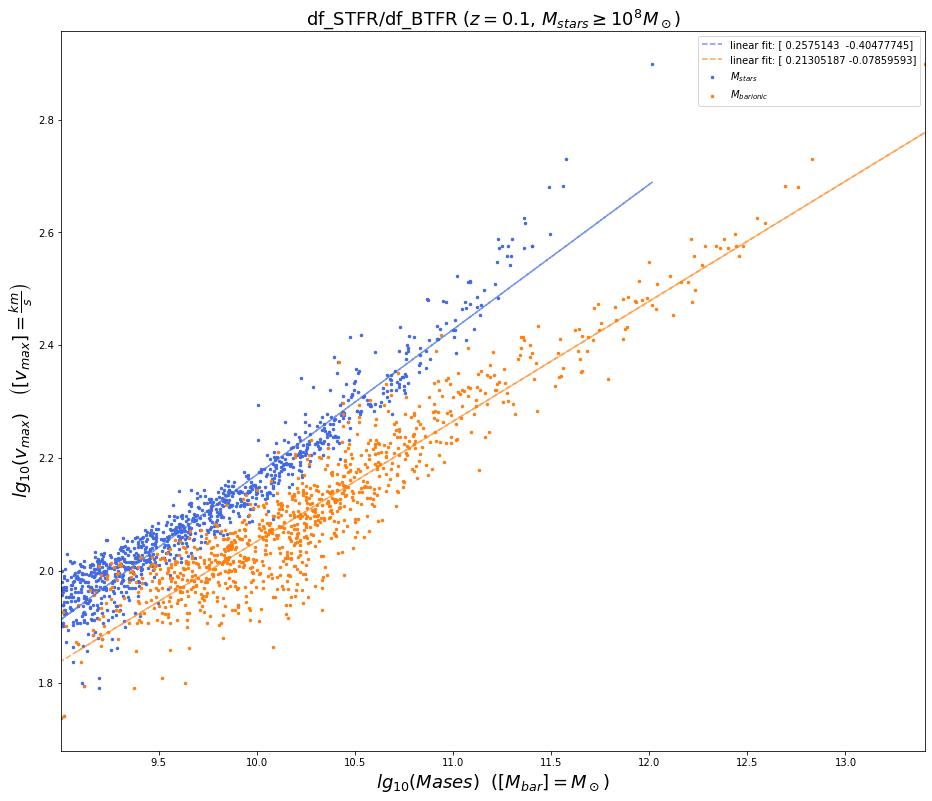

In [ ]:
# figure and axis
fig_SB_TFR= plt.figure(figsize=(12,10))
ax_SB_TFR = fig_SB_TFR.add_axes([0,0,1,1])

# ax, title
ax_SB_TFR.set_title(r'df_STFR/df_BTFR $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
  # STFR
ax_SB_TFR.scatter(x_STFR, y_STFR, s=6, alpha=1, 
                  color='royalblue', label=r'$M_{stars}$')
ax_SB_TFR.plot(x_STFR, fit_STFR[0]*x_STFR + fit_STFR[1], color='royalblue',
        linestyle='--', alpha=0.7, label="linear fit: "+str(fit_STFR))

  # BTFR
ax_SB_TFR.scatter(x_BTFR, y_BTFR, s=6, alpha=1, 
                  color='tab:orange', label=r'$M_{barionic}$')
ax_SB_TFR.plot(x_BTFR, fit_BTFR[0]*x_BTFR + fit_BTFR[1], color='tab:orange',
               linestyle='--', alpha=0.7, label="linear fit: "+str(fit_BTFR))

# Labels
ax_SB_TFR.set_xlabel(r'$lg_{10}(Mases)$  $\left([M_{bar}] = M_\odot\right)$', fontsize=18)
ax_SB_TFR.set_ylabel(r'$lg_{10}(v_{max})$   $\left([v_{max}] = \frac{km}{s}\right)$', fontsize=18)
# Limits
ax_SB_TFR.set_xlim(min(np.concatenate((x_STFR, x_BTFR))),
            max(np.concatenate((x_STFR, x_BTFR))))
# Legend
ax_SB_TFR.legend()

plt.show()

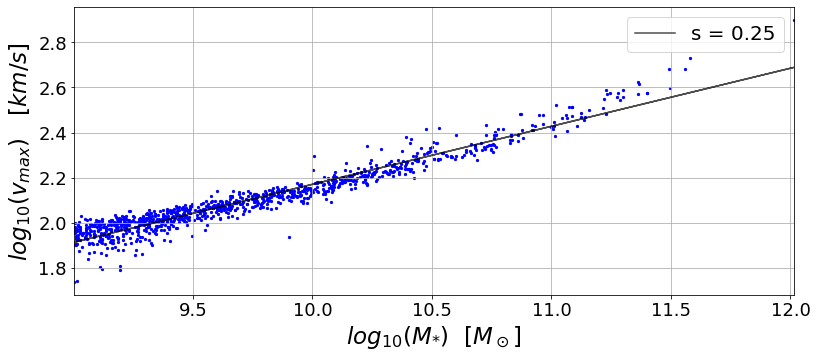

In [ ]:
# figure and axis
fig_SB_TFR= plt.figure(figsize=(10,4))
ax_SB_TFR = fig_SB_TFR.add_axes([0,0,1,1])

# Data
  # STFR
ax_SB_TFR.scatter(x_STFR, y_STFR, s=5, alpha=1, 
                  color='blue')
ax_SB_TFR.plot(x_STFR, fit_STFR[0]*x_STFR + fit_STFR[1], color='black',
        linestyle='-', alpha=0.7, label=r"s = "+str(fit_STFR[0])[0:4])

# Labels
ax_SB_TFR.set_xlabel(r'$log_{10}(M_{*})$  $\left[M_\odot\right]$', fontsize=23)
ax_SB_TFR.set_ylabel(r'$log_{10}(v_{max})$   $\left[km/s\right]$', fontsize=23)
# Limits
ax_SB_TFR.set_xlim(min(x_STFR), max(x_STFR))

# Legend
ax_SB_TFR.legend(fontsize=20)
plt.grid()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

### Stelar mass disc-galaxies TFR

In [ ]:
x_STFR_disc = x_STFR[df_STFR['Disc']== True]
x_STFR_elli = x_STFR[df_STFR['Disc']== False]
y_STFR_disc = y_STFR[df_STFR['Disc']== True]
y_STFR_elli = y_STFR[df_STFR['Disc']== False]
fit_STFR_disc= np.polyfit(x_STFR_disc, y_STFR_disc, 1)
fit_STFR_elli= np.polyfit(x_STFR_elli, y_STFR_elli, 1)

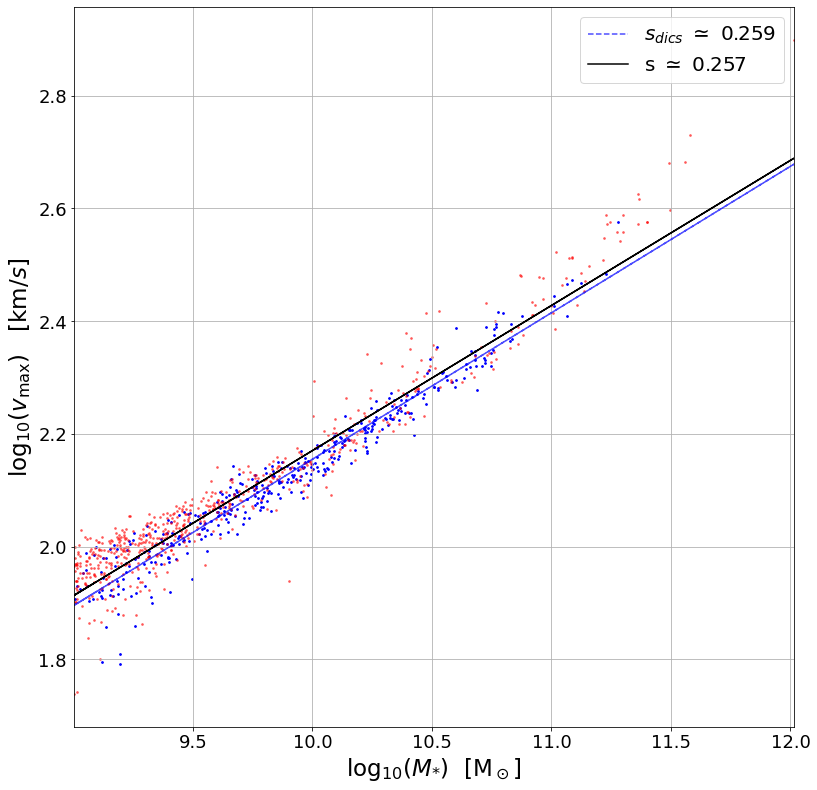

In [ ]:
# figure and axis
fig_SB_TFR_disc= plt.figure(figsize=(10,10))
ax_SB_TFR_disc = fig_SB_TFR_disc.add_axes([0,0,1,1])

# Data
  # STFR_disc
ax_SB_TFR_disc.scatter(x_STFR_disc, y_STFR_disc, s=3, alpha=1, color='blue', )
ax_SB_TFR_disc.plot(x_STFR, fit_STFR_disc[0]*x_STFR+ fit_STFR_disc[1], color='Blue',
        linestyle='--', alpha=0.7, label=r"$s_{dics}$ $\simeq$ "+str(fit_STFR_disc[0])[0:5])

  # STFR_elli
ax_SB_TFR_disc.scatter(x_STFR_elli, y_STFR_elli, s=3, alpha=0.5, color='red')

  # STFR
ax_SB_TFR_disc.plot(x_STFR, fit_STFR[0]*x_STFR + fit_STFR[1], color='black',
        linestyle='-', alpha=1, label=r"s $\simeq$ "+str(fit_STFR[0])[0:5])
# Labels
ax_SB_TFR_disc.set_xlabel(r'$\log_{10}(M_{*})$  $\left[\mathrm{M}_\odot\right]$', fontsize=23)
ax_SB_TFR_disc.set_ylabel(r'$\log_{10}(v_{\mathrm{max}})$   $\left[\mathrm{km}/s\right]$', fontsize=23)
# Limits
ax_SB_TFR_disc.set_xlim(min(x_STFR), max(x_STFR))

# Legend
ax_SB_TFR_disc.legend(fontsize=20)
plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [ ]:
print(fit_STFR_disc)

[ 0.25991246 -0.44409643]


## Morphology relations

### Shape parameter

In a first place, shape parameter ($\epsilon (a,c)$) allow characterize a galaxy morphology

For example, a spherical haloes has the same length in all axis, so: 

$$ \epsilon_{spherical}(a,c=a) = 0$$

While a flattened galaxy, with a posible disc, its major axis is quite larguer than the smaller ($\frac{c}{a}\simeq 0)$, so:

$$\epsilon_{flat}(a,c) \simeq 1$$

This is a poor diagnostif and it is only possible for the data provided by the table MorphoKinem, but it is the first view that can be given.

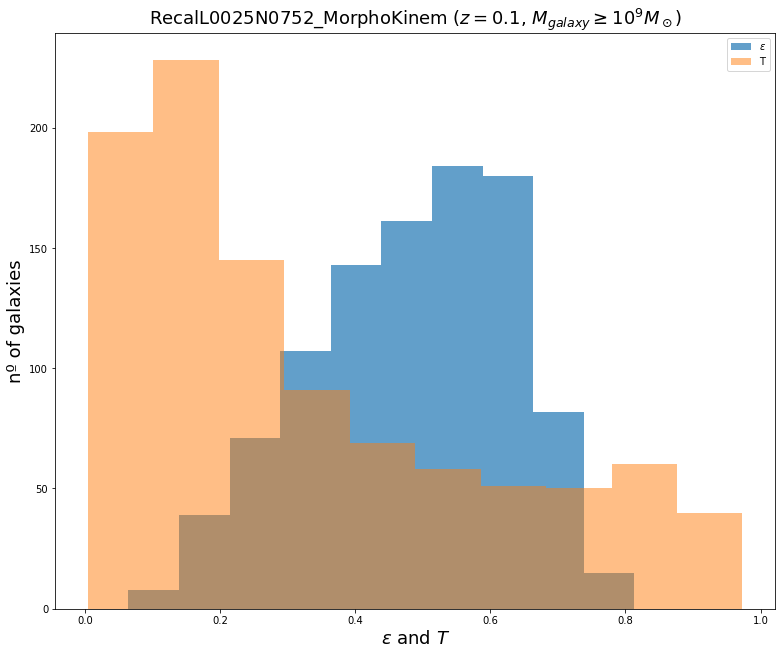

In [ ]:
# figure and axis
fig_shape_1= plt.figure(figsize=(10,8))
ax_shape_1= fig_shape_1.add_axes([0,0,1,1])

# Title
ax_shape_1.set_title(r'RecalL0025N0752_MorphoKinem $(z = 0.1$, $M_{galaxy} \geq 10^9 M_\odot)$', fontsize=18)

# Data
ax_shape_1.hist(df_2['epsilon'], alpha = 0.7, label=r'$\epsilon$')
ax_shape_1.hist(df_2['T'], alpha = 0.5, label=r'T')

# Labels
ax_shape_1.legend()
ax_shape_1.set_ylabel(r'nº of galaxies', fontsize=18)
ax_shape_1.set_xlabel(r'$\epsilon$ and $T$', fontsize=18)


plt.show()

SPEAK ABOUT T.

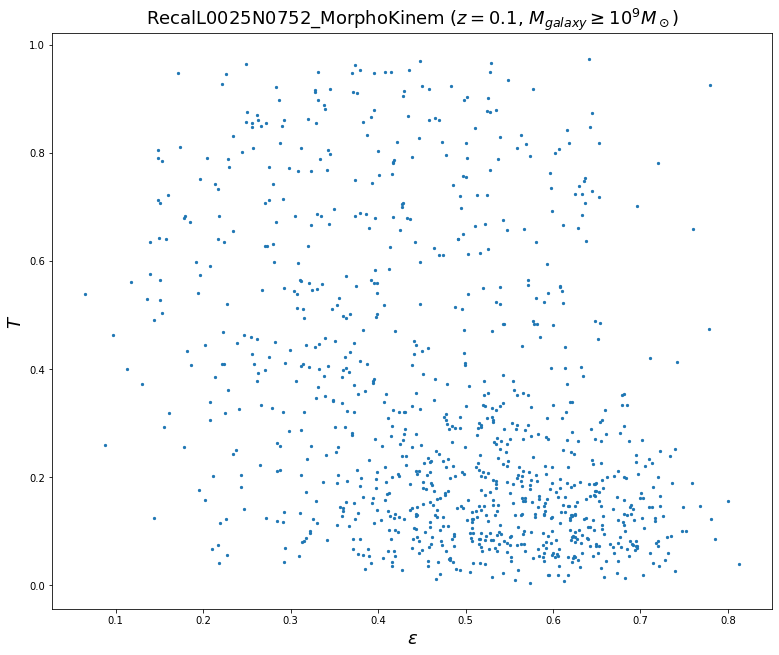

In [ ]:
# figure and axis
fig_shape_2= plt.figure(figsize=(10,8))
ax_shape_2= fig_shape_2.add_axes([0,0,1,1])

# Data
ax_shape_2.scatter(df_2['epsilon'], df_2['T'], s=5)
# Title
ax_shape_2.set_title(r'RecalL0025N0752_MorphoKinem $(z = 0.1$, $M_{galaxy} \geq 10^9 M_\odot)$', fontsize=18)
# Labels
ax_shape_2.set_ylabel(r'$T$', fontsize=18)
ax_shape_2.set_xlabel(r'$\epsilon$', fontsize=18)


plt.show()

### Colour parameter with $M_{galaxy}$

There is a correlation between the colour of the galaxy and its morphology, we can say that if the u filter dominates over the r filter means that galaxy is a blue-cloud-like and this is related to the possible presence of disk in the galaxy. 

We define that u dominates when:

$$ u - r < 0.25 \cdot lg_{10}(M_{galaxy}/M_\odot) - 0.495 $$

where: $M_{galaxy}$ is the total mass of the galaxy (in our database, its units are solar masses).


In [ ]:
df_col_glxy= df.dropna(subset=['u-r', 'Mass'])                                  # df with u-r and Mass information
df_col_glxy[df_col_glxy['u-r'] < 0.25*np.log10(df_col_glxy['Mass']) - 0.495]    # potentially with disk
df_col_glxy 

,Mass,v_max,Mass_stars,Mass_gas,Mass_bar,epsilon,T,k_rot,u-r,Disc
GalaxyID,,,,,,,,,,
165372,2.261959e+10,74.009285,1.220769e+09,0.000000e+00,1.220769e+09,0.207366,0.304865,0.271714,2.302270,False
580563,1.212400e+11,87.035484,1.024681e+09,3.270071e+09,4.294752e+09,0.280752,0.597823,0.172794,1.167559,False
593139,1.237809e+11,98.434052,2.557534e+09,4.873412e+08,3.044875e+09,0.411354,0.062803,0.388590,1.608477,False
599202,1.461041e+11,84.501297,1.023775e+09,0.000000e+00,1.023775e+09,0.310914,0.563807,0.208956,2.189999,False
599648,1.438893e+11,85.922684,1.118190e+09,4.926326e+08,1.610822e+09,0.542521,0.224507,0.345154,1.528059,False
...,...,...,...,...,...,...,...,...,...,...
2639531,1.597899e+13,387.887177,1.992180e+11,1.429076e+12,1.628294e+12,0.629499,0.738506,0.213110,2.356546,False
2656266,1.523952e+13,361.000916,1.983381e+11,1.489303e+12,1.687641e+12,0.479341,0.371278,0.321531,2.220762,False
2670481,1.730008e+14,793.984985,1.034357e+12,2.445943e+13,2.549378e+13,0.447370,0.968948,0.132092,2.355844,False


#### Representation: $(u-r)$ vs $lg_{10}(M_{galaxy}/M_\odot)$

In [ ]:
# Green Valley
GVY_glxy= lambda M: 0.25*np.log10(M) - 0.495
x_GVY_glxy= np.log10(df_col_glxy['Mass']); y_GVY_glxy= GVY_glxy(df_col_glxy['Mass'])

# Blue cloud
df_BCL_glxy= df_col_glxy[df_col_glxy['u-r'] < GVY_glxy(df_col_glxy['Mass'])]
x_BCL_glxy= np.log10(df_BCL_glxy['Mass']); y_BCL_glxy= df_BCL_glxy['u-r']

# Red sequence
df_RSL_glxy= df_col_glxy[df_col_glxy['u-r'] > GVY_glxy(df_col_glxy['Mass'])]
x_RSL_glxy= np.log10(df_RSL_glxy['Mass']); y_RSL_glxy= df_RSL_glxy['u-r']

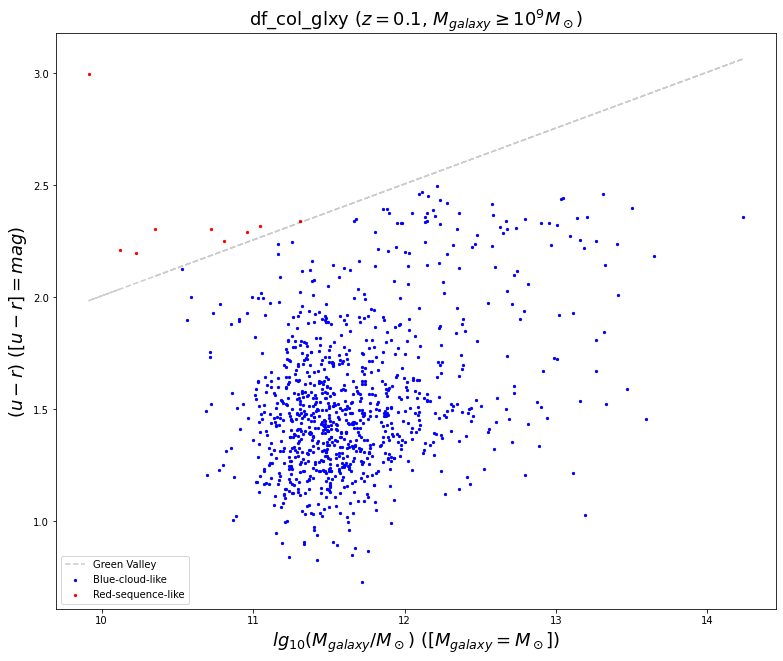

In [ ]:
# figure and axis
fig_col_glxy_1 = plt.figure(figsize= (10,8))
ax_col_glxy = fig_col_glxy_1.add_axes([0,0,1,1])

# Title
ax_col_glxy.set_title(r'df_col_glxy $(z = 0.1$, $M_{galaxy} \geq 10^9 M_\odot)$', fontsize=18)

# Data
  # Blue cloud
ax_col_glxy.scatter(x_BCL_glxy, y_BCL_glxy, s=5, 
           color='blue', label = 'Blue-cloud-like')
  # Red sequence
ax_col_glxy.scatter(x_RSL_glxy, y_RSL_glxy, s=5, 
           color='red', label = 'Red-sequence-like')
  # Green Valley
ax_col_glxy.plot(x_GVY_glxy, y_GVY_glxy, 
        'k--', alpha = 0.2, label= "Green Valley")

# Labels
ax_col_glxy.set_ylabel(r'$(u-r)$ ($[u-r] = mag$)', fontsize=18)
ax_col_glxy.set_xlabel(r'$lg_{10}(M_{galaxy}/M_\odot}$) ($[M_{galaxy} = M_\odot]$)', fontsize=18)
# Legend
ax_col_glxy.legend()

plt.show()

#### Representation: epsilon vs T, with u-r information

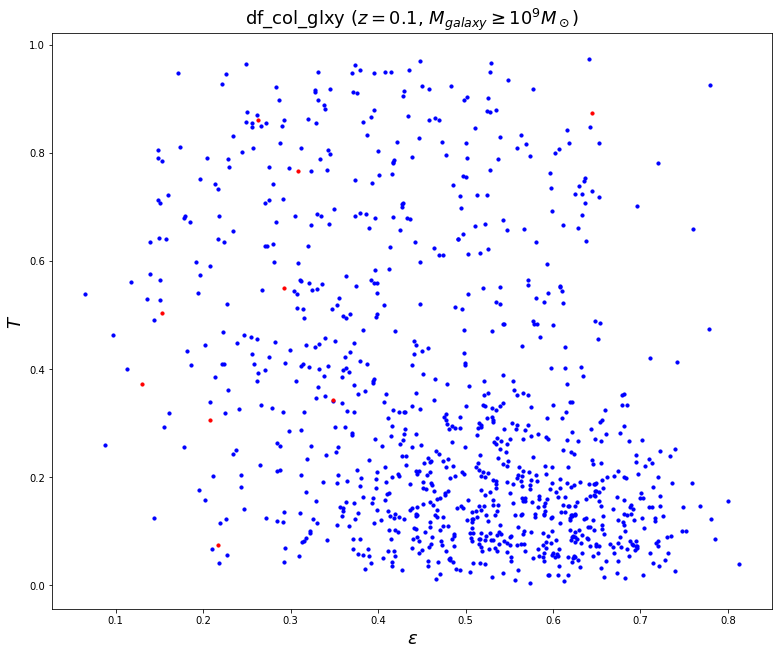

In [ ]:
# figure and axis
fig_col_glxy_2 = plt.figure(figsize=(10,8))
ax_col_glxy= fig_col_glxy_2.add_axes([0,0,1,1])

# Title
ax_col_glxy.set_title(r'df_col_glxy $(z = 0.1$, $M_{galaxy} \geq 10^9 M_\odot)$',
                      fontsize=18)

# Data
  # Blue Cloud
ax_col_glxy.scatter(df_BCL_glxy['epsilon'], df_BCL_glxy['T'], s=10, 
           color = "Blue", label = "Blue cloud like")
  # Red Sequence
ax_col_glxy.scatter(df_RSL_glxy['epsilon'], df_RSL_glxy['T'], s=10, 
           color = "red", label = "Red Sequence like")

# Labels
ax_col_glxy.set_ylabel(r'$T$', fontsize=18)
ax_col_glxy.set_xlabel(r'$\epsilon$', fontsize=18)


plt.show()

The information that can be extracted from this is not at all clear, the only thing I see is that the reds do not go beyond an $\epsilon > 0.5$, but there is not enough data to extract anything clear.

### Colour parameter with $M_{stars}$

There is a correlation between the colour of the galaxy and its morphology, we can say that if the u filter dominates over the r filter means that galaxy is a blue-cloud-like and this is related to the possible presence of disk in the galaxy. 

We define that u dominates when:

$$ u - r < 0.25 \cdot lg_{10}(M_{stars}/M_\odot) - 0.495 $$

where: $M_{stars}$ is the baryonic mass of the galaxy (in our database, its units are solar masses).


In [ ]:
df_col_stars = df.dropna(subset=['u-r', 'Mass_stars'])           # df with u-r and Mass_stars information
df_col_stars[df_col_stars['u-r'] < 0.25*np.log10(df_col_stars['Mass_stars']) - 0.495] # potentially with disk
df_col_stars

,Mass,v_max,Mass_stars,Mass_gas,Mass_bar,epsilon,T,k_rot,u-r,Disc
GalaxyID,,,,,,,,,,
165372,2.261959e+10,74.009285,1.220769e+09,0.000000e+00,1.220769e+09,0.207366,0.304865,0.271714,2.302270,False
580563,1.212400e+11,87.035484,1.024681e+09,3.270071e+09,4.294752e+09,0.280752,0.597823,0.172794,1.167559,False
593139,1.237809e+11,98.434052,2.557534e+09,4.873412e+08,3.044875e+09,0.411354,0.062803,0.388590,1.608477,False
599202,1.461041e+11,84.501297,1.023775e+09,0.000000e+00,1.023775e+09,0.310914,0.563807,0.208956,2.189999,False
599648,1.438893e+11,85.922684,1.118190e+09,4.926326e+08,1.610822e+09,0.542521,0.224507,0.345154,1.528059,False
...,...,...,...,...,...,...,...,...,...,...
2639531,1.597899e+13,387.887177,1.992180e+11,1.429076e+12,1.628294e+12,0.629499,0.738506,0.213110,2.356546,False
2656266,1.523952e+13,361.000916,1.983381e+11,1.489303e+12,1.687641e+12,0.479341,0.371278,0.321531,2.220762,False
2670481,1.730008e+14,793.984985,1.034357e+12,2.445943e+13,2.549378e+13,0.447370,0.968948,0.132092,2.355844,False


#### Representation: $(u-r)$ vs $lg_{10}(M_{stars}/M_\odot)$

In [ ]:
# Green Valley
GVY_stars= lambda M: 0.25*np.log10(M) - 0.495
x_GVY_stars= np.log10(df_col_stars['Mass_stars'])
y_GVY_stars= GVY_stars(df_col_stars['Mass_stars'])

# Blue cloud
df_BCL_stars= df_col_stars[df_col_stars['u-r'] < GVY_stars(df_col_stars['Mass_stars'])]
x_BCL_stars= np.log10(df_BCL_stars['Mass_stars']); y_BCL_stars= df_BCL_stars['u-r']

# Red sequence
df_RSL_stars= df_col_stars[df_col_stars['u-r'] > GVY_stars(df_col_stars['Mass_stars'])]
x_RSL_stars= np.log10(df_RSL_stars['Mass_stars']); y_RSL_stars= df_RSL_stars['u-r']

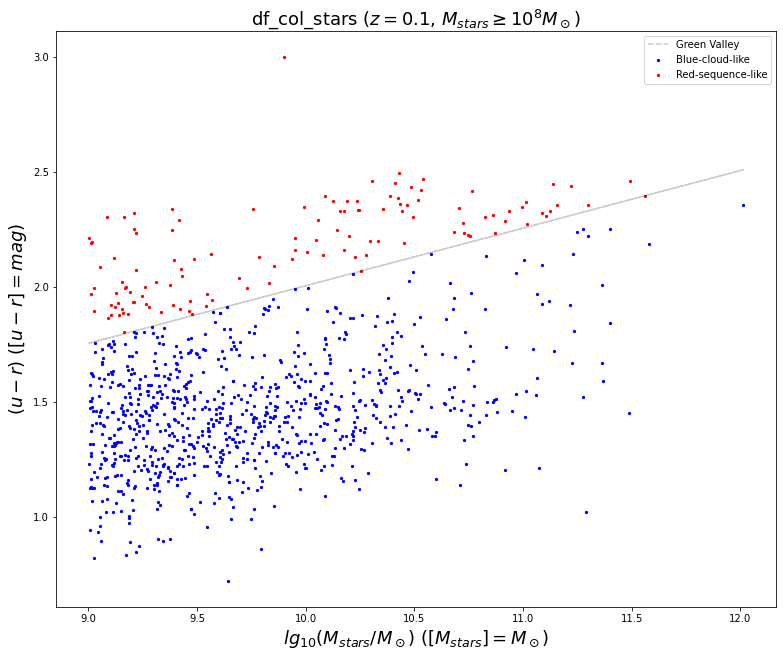

In [ ]:
# figure and axis
fig_col_stars_1= plt.figure(figsize=(10,8))
ax_col_stars_1= fig_col_stars_1.add_axes([0,0,1,1])

# Title
ax_col_stars_1.set_title(r'df_col_stars $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
  # Blue cloud
ax_col_stars_1.scatter(x_BCL_stars, y_BCL_stars, s=5, 
           color='blue', label = 'Blue-cloud-like')
  # Red sequence
ax_col_stars_1.scatter(x_RSL_stars, y_RSL_stars, s=5, 
           color='red', label = 'Red-sequence-like')
  # Green Valley
ax_col_stars_1.plot(x_GVY_stars, y_GVY_stars, 
        'k--', alpha = 0.2, label= "Green Valley")

# Labels
ax_col_stars_1.set_ylabel(r'$(u-r)$ ($[u-r] = mag$)', fontsize=18)
ax_col_stars_1.set_xlabel(r'$lg_{10}(M_{stars}/M_\odot}$) ($[M_{stars}] = M_\odot$)', fontsize=18)
# Leyenda
ax_col_stars_1.legend()


plt.show()

#### Representation: epsilon vs T, with u-r information

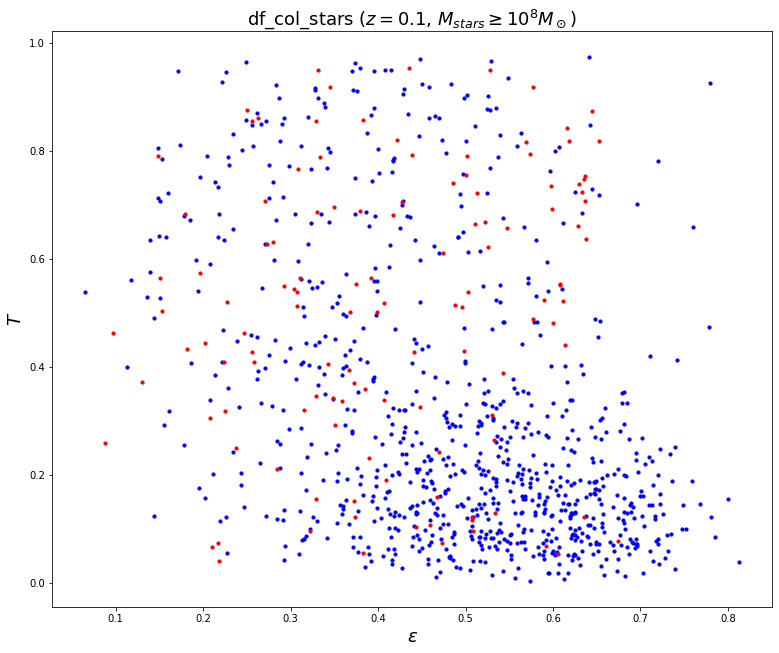

In [ ]:
# figure and axis
fig_col_stars_2= plt.figure(figsize=(10,8))
ax_col_stars_2= fig_col_stars_2.add_axes([0,0,1,1])

# Title
ax_col_stars_2.set_title(r'df_col_stars $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
  # Blue Cloud
ax_col_stars_2.scatter(df_BCL_stars['epsilon'], df_BCL_stars['T'], s=10, 
           color = "Blue", label = "Blue cloud like")
  # Red Sequence
ax_col_stars_2.scatter(df_RSL_stars['epsilon'], df_RSL_stars['T'], s=10, 
           color = "red", label = "Red Sequence like")

# Labels
ax_col_stars_2.set_ylabel(r'$T$', fontsize=18)
ax_col_stars_2.set_xlabel(r'$\epsilon$', fontsize=18)


plt.show()

In this case the information is, I think, less clear. There is red points with $\epsilon \simeq 0.65$ and $T \simeq 0$.

### Representation $k_{rot}$ vs $lg_{10}\left(M_{stars}\right)$

In [ ]:
df_krot = df.dropna(subset=['k_rot', 'Mass_stars']); df_krot          # df with k_rot and Mass_stars information

,Mass,v_max,Mass_stars,Mass_gas,Mass_bar,epsilon,T,k_rot,u-r,Disc
GalaxyID,,,,,,,,,,
165372,2.261959e+10,74.009285,1.220769e+09,0.000000e+00,1.220769e+09,0.207366,0.304865,0.271714,2.302270,False
580563,1.212400e+11,87.035484,1.024681e+09,3.270071e+09,4.294752e+09,0.280752,0.597823,0.172794,1.167559,False
593139,1.237809e+11,98.434052,2.557534e+09,4.873412e+08,3.044875e+09,0.411354,0.062803,0.388590,1.608477,False
599202,1.461041e+11,84.501297,1.023775e+09,0.000000e+00,1.023775e+09,0.310914,0.563807,0.208956,2.189999,False
599648,1.438893e+11,85.922684,1.118190e+09,4.926326e+08,1.610822e+09,0.542521,0.224507,0.345154,1.528059,False
...,...,...,...,...,...,...,...,...,...,...
2639531,1.597899e+13,387.887177,1.992180e+11,1.429076e+12,1.628294e+12,0.629499,0.738506,0.213110,2.356546,False
2656266,1.523952e+13,361.000916,1.983381e+11,1.489303e+12,1.687641e+12,0.479341,0.371278,0.321531,2.220762,False
2670481,1.730008e+14,793.984985,1.034357e+12,2.445943e+13,2.549378e+13,0.447370,0.968948,0.132092,2.355844,False


In [ ]:
# Disc
x_disc= np.log10(df_krot[df_krot['Disc']]['Mass_stars'])
y_disc= df_krot[df_krot['Disc']]['k_rot']

#Ellipse
Ellipse = df_krot[[not i for i in df_krot['Disc']]]
x_ellip= np.log10(Ellipse['Mass_stars'])
y_ellip= Ellipse['k_rot']

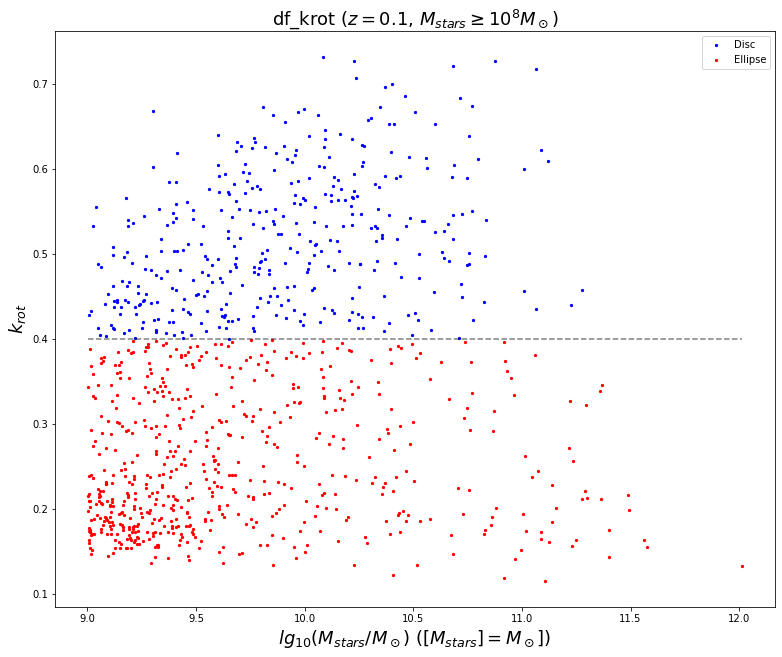

In [ ]:
# figure and axis
fig_krot= plt.figure(figsize=(10,8))
ax_krot= fig_krot.add_axes([0,0,1,1])

# Title
ax_krot.set_title(r'df_krot $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
  # Disc
ax_krot.scatter(x_disc, y_disc, s=5, 
           color='blue', label = 'Disc')
  # Red sequence
ax_krot.scatter(x_ellip, y_ellip, s=5, 
           color='red', label = 'Ellipse')

 # Condition 
ax_krot.hlines(0.4, min(np.log10(df_krot['Mass_stars'])), 
               max(np.log10(df_krot['Mass_stars'])), 
          colors='k', linestyles='--', alpha=0.5)

# Labels
ax_krot.set_ylabel(r'$k_{rot}$', fontsize=18)
ax_krot.set_xlabel(r'$lg_{10}(M_{stars}/M_\odot}$) ($[M_{stars}] = M_\odot]$)', fontsize=18)
ax_krot.legend()

plt.show()

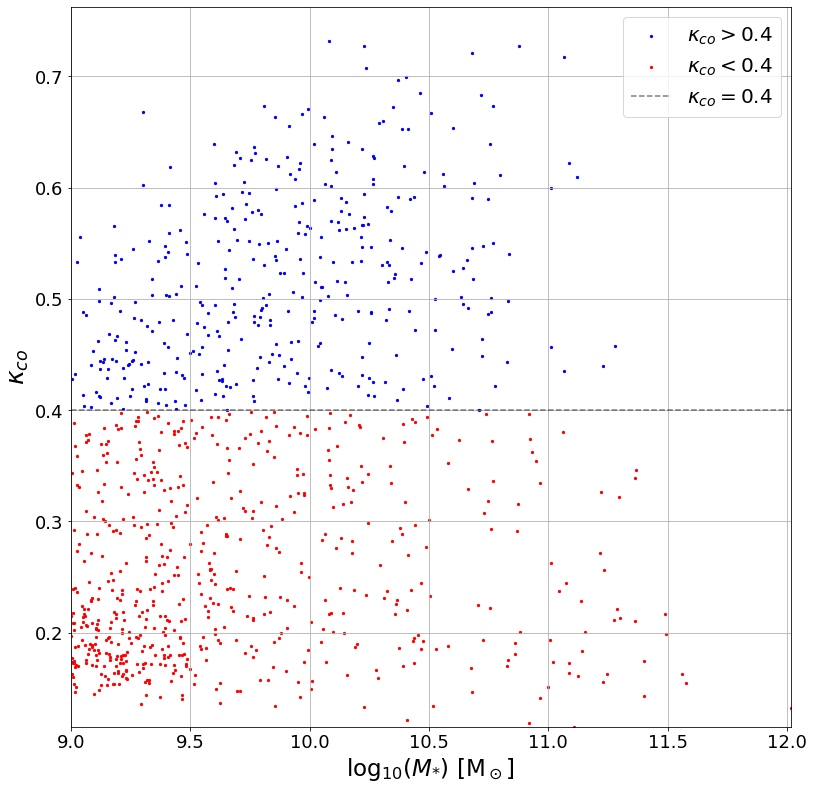

In [ ]:
# figure and axis
fig_krot= plt.figure(figsize=(10,10))
ax_krot= fig_krot.add_axes([0,0,1,1])

# Title
ax_krot.set_title(r'', fontsize=18)

# Data
  # Disc
ax_krot.scatter(x_disc, y_disc, s=5, 
           color='blue', label = r'$\kappa_{co} > 0.4$')
  # Red sequence
ax_krot.scatter(x_ellip, y_ellip, s=5, 
           color='red', label = r'$\kappa_{co} < 0.4$')

 # Condition 
ax_krot.hlines(0.4, min(np.log10(df_krot['Mass_stars'])), 
               max(np.log10(df_krot['Mass_stars'])), 
          colors='k', linestyles='--', alpha=0.5, label= r'$\kappa_{co} = 0.4$')

# Labels
ax_krot.set_ylabel(r'$\kappa_{co}$', fontsize=25)
ax_krot.set_xlabel(r'$\log_{10}(M_{*}}$) $[\mathrm{M}_\odot]$', fontsize=23)
ax_krot.legend(fontsize=20)

ax_krot.set_xlim(9, np.log10(max(df_krot['Mass_stars'])))
ax_krot.set_ylim(min(y_ellip))
plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## Distribution Function

### First Histogram: $M_{stars}$

In [ ]:
df_hist_m_stars= df.dropna(subset= ['Mass_stars'])

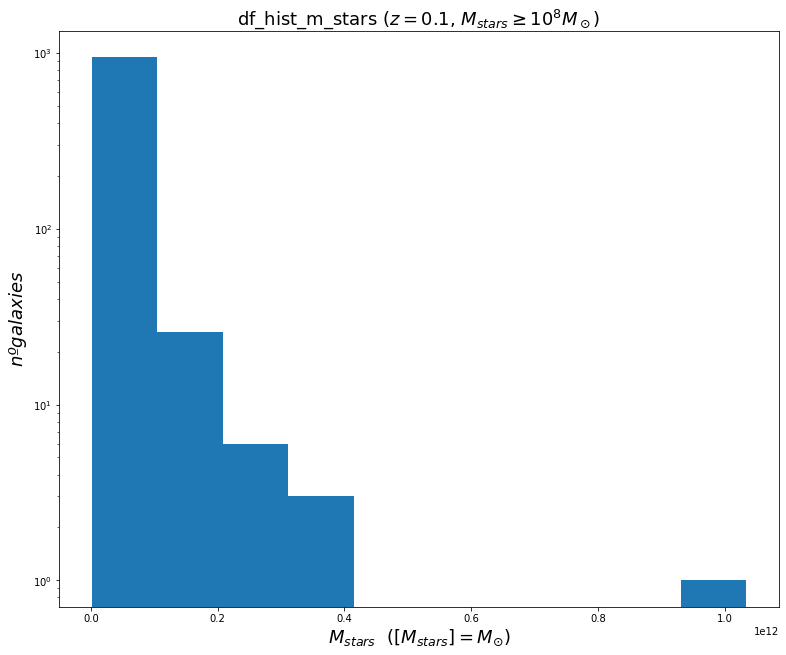

In [ ]:
fig_hist_m_stars= plt.figure(figsize=(10,8))
ax_hist_m_stars= fig_hist_m_stars.add_axes([0,0,1,1])

# Title
ax_hist_m_stars.set_title(r'df_hist_m_stars $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_m_stars.hist(df_hist_m_stars['Mass_stars'])
ax_hist_m_stars.set_yscale('log')

# Labels
ax_hist_m_stars.set_xlabel(r'$M_{stars}$  $\left([M_{stars}]=M_{\odot}\right)$', fontsize=18)
ax_hist_m_stars.set_ylabel(r'$nºgalaxies$', fontsize=18)

plt.show()

### for disc

In [ ]:
df_hist_m_stars_disc= df.dropna(subset= ['Mass_stars'])[df['Disc'] == True]

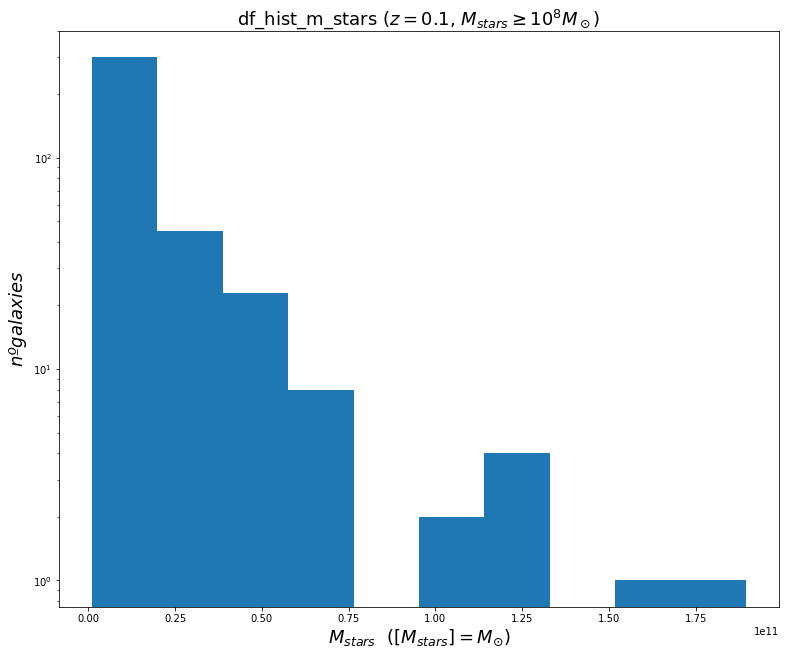

In [ ]:
fig_hist_m_stars_disc= plt.figure(figsize=(10,8))
ax_hist_m_stars_disc= fig_hist_m_stars_disc.add_axes([0,0,1,1])

# Title
ax_hist_m_stars_disc.set_title(r'df_hist_m_stars $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_m_stars_disc.hist(df_hist_m_stars_disc['Mass_stars'])
ax_hist_m_stars_disc.set_yscale('log')

# Labels
ax_hist_m_stars_disc.set_xlabel(r'$M_{stars}$  $\left([M_{stars}]=M_{\odot}\right)$', fontsize=18)
ax_hist_m_stars_disc.set_ylabel(r'$nºgalaxies$', fontsize=18)

plt.show()

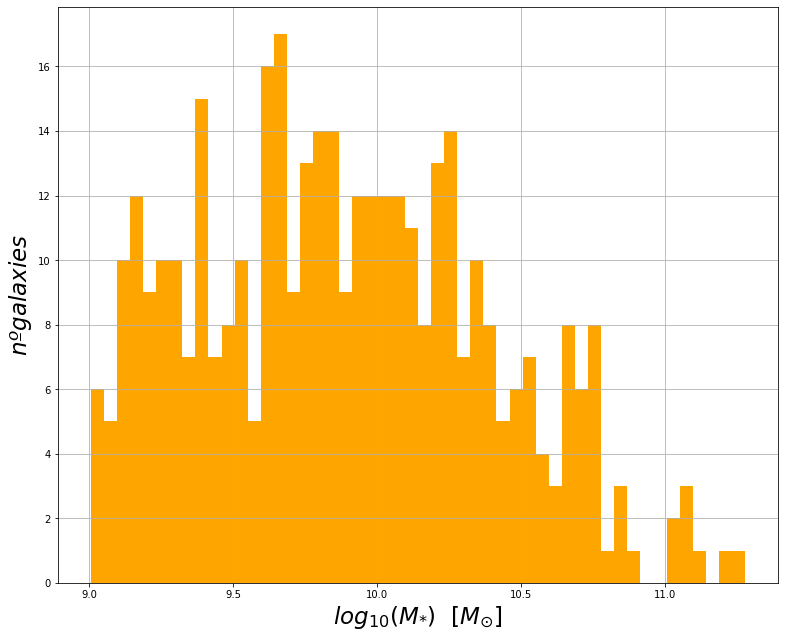

In [ ]:
fig_hist_m_stars_disc= plt.figure(figsize=(10,8))
ax_hist_m_stars_disc= fig_hist_m_stars_disc.add_axes([0,0,1,1])

# Data
ax_hist_m_stars_disc.hist(np.log10(df_hist_m_stars_disc['Mass_stars']), bins=50, color='orange')

# Labels
ax_hist_m_stars_disc.set_xlabel(r'$log_{10}(M_{*})$  $\left[M_{\odot}\right]$', fontsize=23)
ax_hist_m_stars_disc.set_ylabel(r'$nºgalaxies$', fontsize=23)
ax_hist_m_stars_disc.grid()

plt.show()

### All

In [ ]:
df_hist_m_stars_elli= df.dropna(subset= ['Mass_stars'])[df['Disc'] == False]

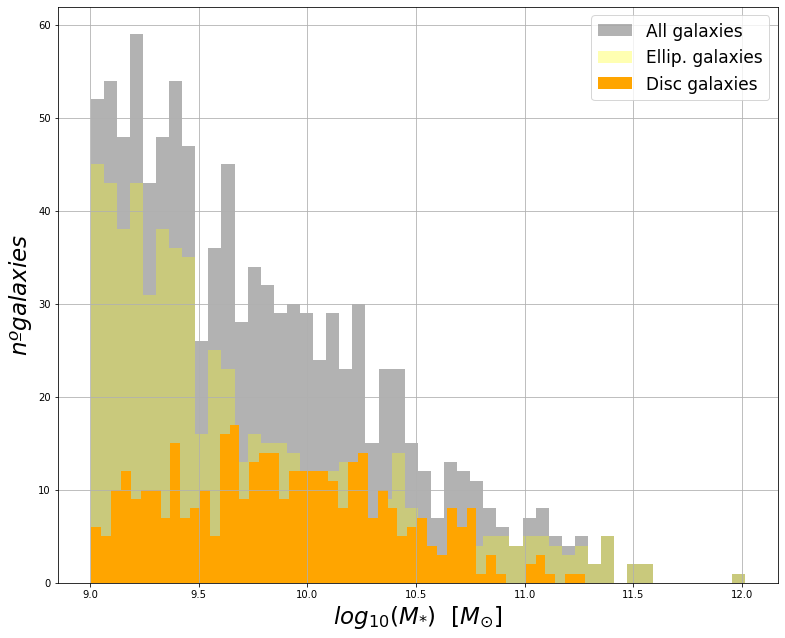

In [ ]:
fig_hist_m_stars_all= plt.figure(figsize=(10,8))
ax_hist_m_stars_all = fig_hist_m_stars_all.add_axes([0,0,1,1])

# Data
ax_hist_m_stars_all.hist(np.log10(df_hist_m_stars['Mass_stars']), bins=50, alpha=0.3, color='Black', label='All galaxies')
ax_hist_m_stars_all.hist(np.log10(df_hist_m_stars_elli['Mass_stars']), bins=50, alpha=0.3, color='yellow', label='Ellip. galaxies')
ax_hist_m_stars_all.hist(np.log10(df_hist_m_stars_disc['Mass_stars']), bins=50, color='orange', label = 'Disc galaxies')

# Labels
ax_hist_m_stars_all.set_xlabel(r'$log_{10}(M_{*})$  $\left[M_{\odot}\right]$', fontsize=23)
ax_hist_m_stars_all.set_ylabel(r'$nºgalaxies$', fontsize=23)
ax_hist_m_stars_all.grid()
ax_hist_m_stars_all.legend(fontsize=17)

plt.show()

### Second Histogram: $v_{max}$

In [ ]:
df_hist_v_max= df.dropna(subset= ['v_max'])

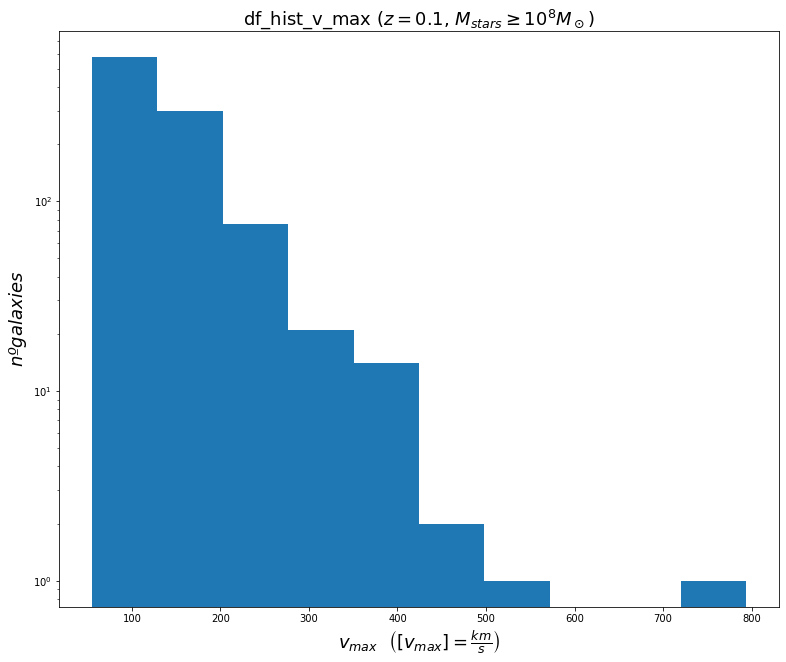

In [ ]:
fig_hist_v_max= plt.figure(figsize=(10,8))
ax_hist_v_max= fig_hist_v_max.add_axes([0,0,1,1])

# Title
ax_hist_v_max.set_title(r'df_hist_v_max $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_v_max.hist(df_hist_v_max['v_max'])
ax_hist_v_max.set_yscale('log')

#label
ax_hist_v_max.set_xlabel(r'$v_{max}$  $\left([v_{max}]=\frac{km}{s}\right)$', fontsize=18)
ax_hist_v_max.set_ylabel(r'$nºgalaxies$', fontsize=18)

plt.show()

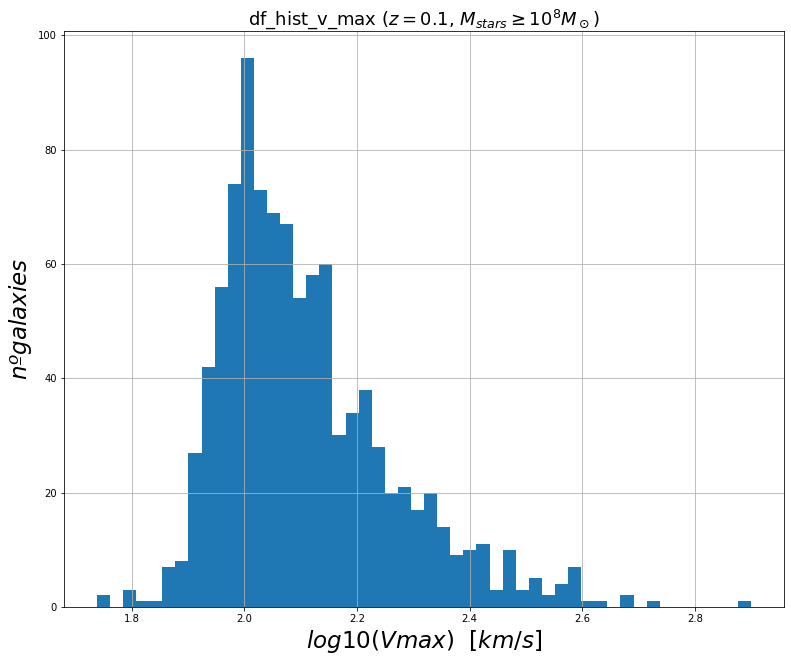

In [ ]:
fig_hist_v_max= plt.figure(figsize=(10,8))
ax_hist_v_max= fig_hist_v_max.add_axes([0,0,1,1])

# Title
ax_hist_v_max.set_title(r'df_hist_v_max $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_v_max.hist(np.log10(df_hist_v_max['v_max']), bins=50)

#label
ax_hist_v_max.set_xlabel(r'$log10(Vmax)$  $\left[km/s\right]$', fontsize=23)
ax_hist_v_max.set_ylabel(r'$nºgalaxies$', fontsize=23)
plt.grid()

plt.show()

### for disc

In [ ]:
df_hist_v_max_disc= df.dropna(subset= ['v_max'])[df['Disc']==True]

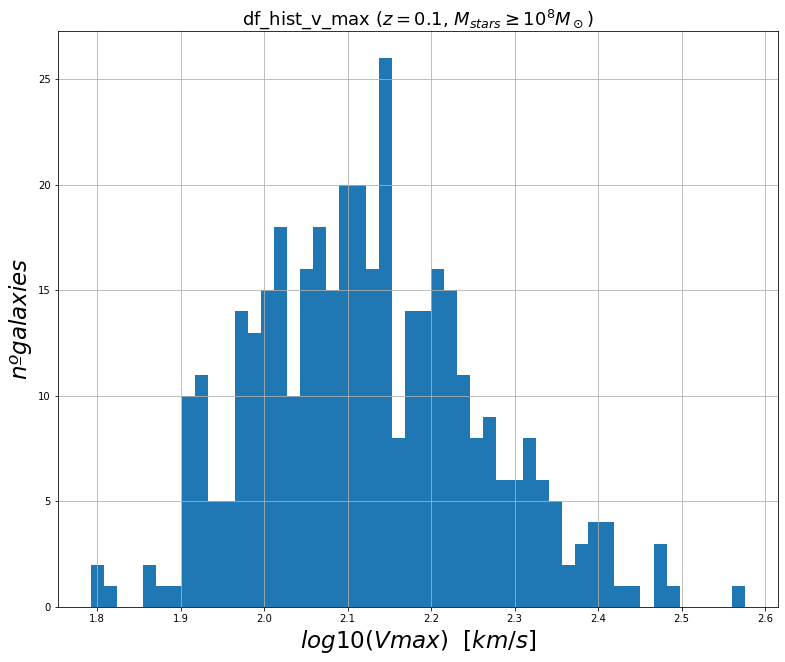

In [ ]:
fig_hist_v_max_disc= plt.figure(figsize=(10,8))
ax_hist_v_max_disc= fig_hist_v_max_disc.add_axes([0,0,1,1])

# Title
ax_hist_v_max_disc.set_title(r'df_hist_v_max $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_v_max_disc.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50)

#label
ax_hist_v_max_disc.set_xlabel(r'$log10(Vmax)$  $\left[km/s\right]$', fontsize=23)
ax_hist_v_max_disc.set_ylabel(r'$nºgalaxies$', fontsize=23)
plt.grid()

plt.show()

### for elliptical

In [ ]:
df_hist_v_max_elli= df.dropna(subset= ['v_max'])[df['Disc']==False]

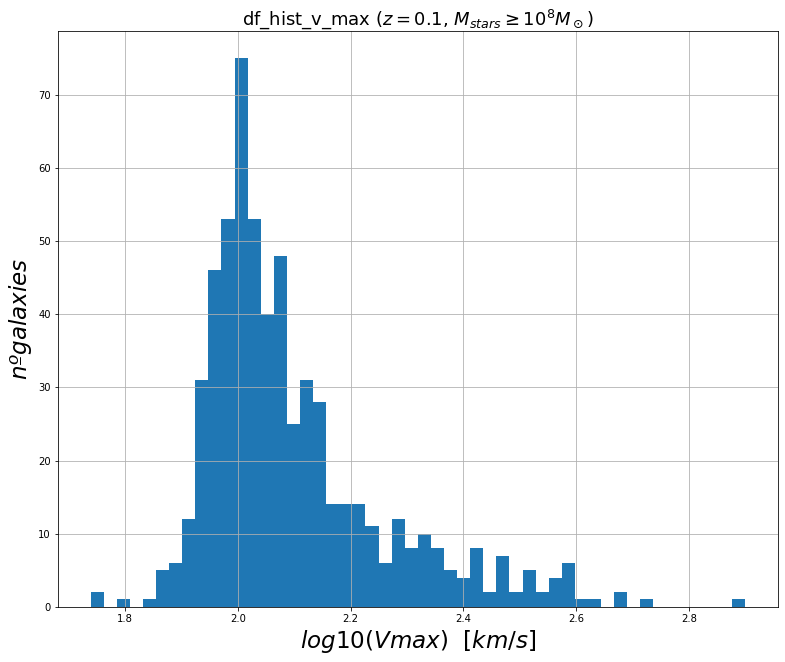

In [ ]:
fig_hist_v_max_elli= plt.figure(figsize=(10,8))
ax_hist_v_max_elli= fig_hist_v_max_elli.add_axes([0,0,1,1])

# Title
ax_hist_v_max_elli.set_title(r'df_hist_v_max $(z = 0.1$, $M_{stars} \geq 10^8 M_\odot)$', fontsize=18)

# Data
ax_hist_v_max_elli.hist(np.log10(df_hist_v_max_elli['v_max']), bins=50)

#label
ax_hist_v_max_elli.set_xlabel(r'$log10(Vmax)$  $\left[km/s\right]$', fontsize=23)
ax_hist_v_max_elli.set_ylabel(r'$nºgalaxies$', fontsize=23)
plt.grid()

plt.show()

### Together

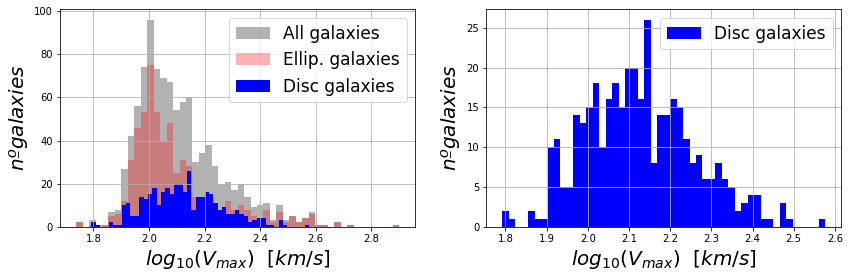

In [ ]:
fig_hist_v_max_all= plt.figure(figsize=(14,4))
ax_hist_v_max_all= fig_hist_v_max_all.add_subplot(121)
ax_hist_v_max_disc= fig_hist_v_max_all.add_subplot(122)

# Data
ax_hist_v_max_all.hist(np.log10(df_hist_v_max['v_max']), bins=50, color= 'Black', alpha = 0.3, label='All galaxies')
ax_hist_v_max_all.hist(np.log10(df_hist_v_max_elli['v_max']), bins=50, color = 'red', alpha = 0.3, label='Ellip. galaxies')
ax_hist_v_max_all.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50, color = 'Blue', label = 'Disc galaxies')

#label
ax_hist_v_max_all.set_xlabel(r'$log_{10}(V_{max})$  $\left[km/s\right]$', fontsize=20)
ax_hist_v_max_all.set_ylabel(r'$nºgalaxies$', fontsize=20)
ax_hist_v_max_all.legend(fontsize=17)
ax_hist_v_max_all.grid()

# Data
ax_hist_v_max_disc.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50,color = 'Blue', label = 'Disc galaxies')

#label
ax_hist_v_max_disc.set_xlabel(r'$log_{10}(V_{max})$  $\left[km/s\right]$', fontsize=20)
ax_hist_v_max_disc.set_ylabel(r'$nºgalaxies$', fontsize=20)
ax_hist_v_max_disc.legend(fontsize=17)
ax_hist_v_max_disc.grid()



plt.show()

### Comparison $M_{stars}$ and $v_{max}$

In [ ]:
df_hist_com= df.dropna(subset= ['Mass_stars', 'v_max'])
norm_m_stars= df_hist_com['Mass_stars']/max(df_hist_com['Mass_stars'])
norm_v_max= df_hist_com['v_max']/max(df_hist_com['v_max'])

[]

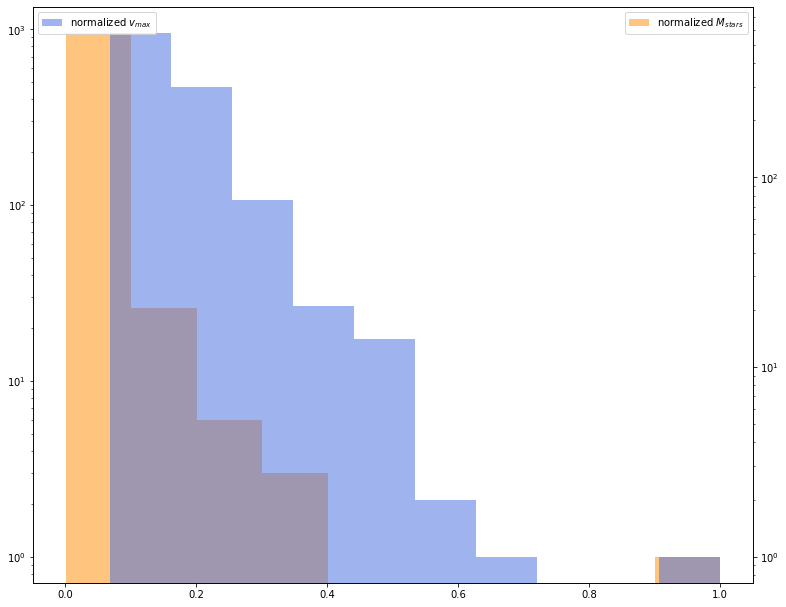

In [ ]:
fig_hist_com= plt.figure(figsize=(10,8))
ax_hist_com_1= fig_hist_com.add_axes([0,0,1,1])
ax_hist_com_2= ax_hist_com_1.twinx()

# Title


# Data
  # m_stars
ax_hist_com_1.hist(norm_m_stars, color= "darkorange", alpha= 0.5, 
                   label= r'normalized $M_{stars}$')
ax_hist_com_1.set_yscale('log')

  # v_max
ax_hist_com_2.hist(norm_v_max, color= "royalblue", alpha=0.5, 
                   label= r'normalized $v_{max}$')
ax_hist_com_2.set_yscale('log')

# Legend
ax_hist_com_1.legend(loc=1)
ax_hist_com_2.legend(loc=2)

plt.plot()

### for disc

In [ ]:
df_hist_com_disc= df.dropna(subset= ['Mass_stars', 'v_max'])[df['Disc'] == True]
norm_m_stars_disc= df_hist_com_disc['Mass_stars']/max(df_hist_com_disc['Mass_stars'])
norm_v_max_disc= df_hist_com_disc['v_max']/max(df_hist_com_disc['v_max'])

[]

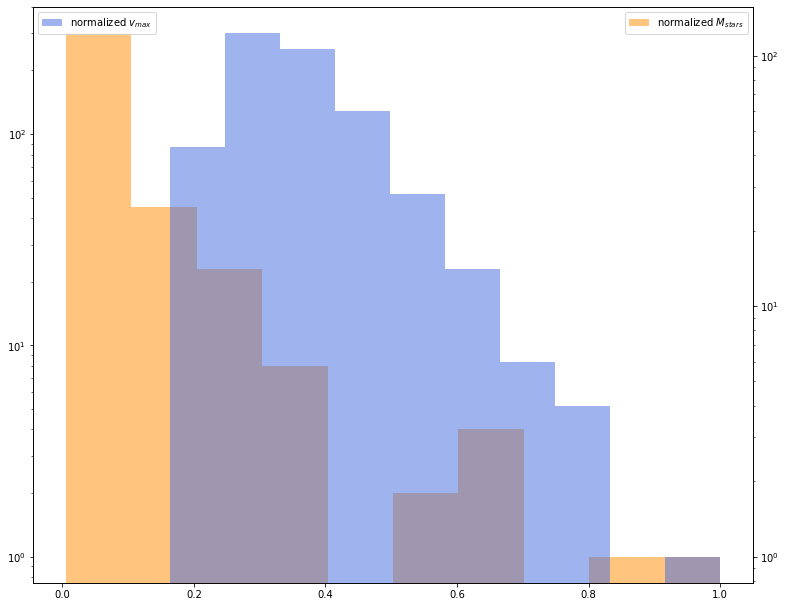

In [ ]:
fig_hist_com_disc= plt.figure(figsize=(10,8))
ax_hist_com_1_disc= fig_hist_com_disc.add_axes([0,0,1,1])
ax_hist_com_2_disc= ax_hist_com_1_disc.twinx()

# Title


# Data
  # m_stars
ax_hist_com_1_disc.hist(norm_m_stars_disc, color= "darkorange", alpha= 0.5, 
                   label= r'normalized $M_{stars}$')
ax_hist_com_1_disc.set_yscale('log')

  # v_max
ax_hist_com_2_disc.hist(norm_v_max_disc, color= "royalblue", alpha=0.5, 
                   label= r'normalized $v_{max}$')
ax_hist_com_2_disc.set_yscale('log')

# Legend
ax_hist_com_1_disc.legend(loc=1)
ax_hist_com_2_disc.legend(loc=2)

plt.plot()

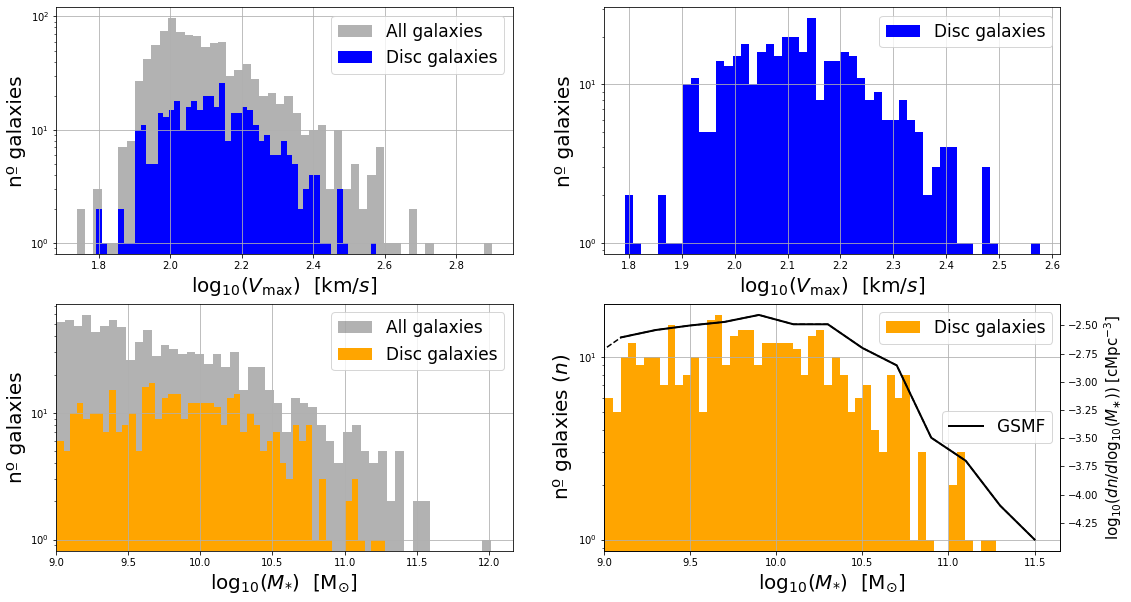

In [ ]:
fig_hist_all= plt.figure(figsize=(18,10))
ax_hist_v_max_all= fig_hist_all.add_subplot(221)
ax_hist_v_max_disc= fig_hist_all.add_subplot(222)
ax_hist_m_stars_all = fig_hist_all.add_subplot(223)


# 221
# Data
ax_hist_v_max_all.hist(np.log10(df_hist_v_max['v_max']), bins=50, color= 'Black', alpha = 0.3, label='All galaxies')
ax_hist_v_max_all.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50, color = 'Blue', label = 'Disc galaxies')

#label
ax_hist_v_max_all.set_xlabel(r'$\log_{10}(V_{\mathrm{max}})$  $\left[\mathrm{km}/s\right]$', fontsize=20)
ax_hist_v_max_all.set_ylabel(r'nº galaxies', fontsize=20)
ax_hist_v_max_all.legend(fontsize=17)
ax_hist_v_max_all.grid()
ax_hist_v_max_all.set_yscale('log')

# 222
# Data
ax_hist_v_max_disc.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50,color = 'Blue', label = 'Disc galaxies')

#label
ax_hist_v_max_disc.set_xlabel(r'$\log_{10}(V_{\mathrm{max}})$  $\left[\mathrm{km}/s\right]$', fontsize=20)
ax_hist_v_max_disc.set_ylabel(r'nº galaxies', fontsize=20)
ax_hist_v_max_disc.legend(fontsize=17)
ax_hist_v_max_disc.grid()
ax_hist_v_max_disc.set_yscale('log')

# 223
# Data
ax_hist_m_stars_all.hist(np.log10(df_hist_m_stars['Mass_stars']), bins=50, alpha=0.3, color='Black', label='All galaxies')
ax_hist_m_stars_all.hist(np.log10(df_hist_m_stars_disc['Mass_stars']), bins=50, color='orange', label = 'Disc galaxies')

# Labels
ax_hist_m_stars_all.set_xlabel(r'$\log_{10}(M_{*})$  $\left[\mathrm{M}_{\odot}\right]$', fontsize=20)
ax_hist_m_stars_all.set_ylabel(r'nº galaxies', fontsize=20)
ax_hist_m_stars_all.grid()
ax_hist_m_stars_all.legend(fontsize=17)

ax_hist_m_stars_all.set_xlim(9)
ax_hist_m_stars_all.set_yscale('log')

# 224
# Data
ax_hist_disc= fig_hist_all.add_subplot(224)
ax_hist_disc_2 = ax_hist_disc.twinx()

sim_name = 'RefL0050N0752'
sim_size = '50'

myQuery = "SELECT \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 AS mass, \
                count(*) AS num \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E07 AND \
                SH.SnapNum = 27 AND \
                MK.KappaCoRot >= 0.4 \
          GROUP BY \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 \
          ORDER BY \
                mass"%(sim_name, sim_name)                  


myData = eagle.execute_query(con, myQuery)
# Normalize by volume and bin width.
hist = myData['num'][:] / float(sim_size)**3.
hist = hist / 0.2

ax_hist_disc.hist(np.log10(df_hist_m_stars_disc['Mass_stars']),label = 'Disc galaxies',
                  bins=50, color='orange')
ax_hist_disc.set_yscale('log')
ax_hist_disc_2.plot(myData['mass'][myData['mass']>9], np.log10(hist)[myData['mass']>9], 'k-',linewidth=2, label='GSMF')
ax_hist_disc_2.plot(myData['mass'][myData['mass']>8], np.log10(hist)[myData['mass']>8], 'k--')

# Label plot.
ax_hist_disc.set_xlabel(r'$\log_{10}(M_{*})$  $\left[\mathrm{M}_{\odot}\right]$', fontsize=20) 
ax_hist_disc.set_ylabel(r'nº galaxies $(n)$', fontsize=20)
ax_hist_disc_2.set_ylabel(r'$\log_{10}\left(dn/d\log_{10}(M_{∗})\right)$ [$\mathrm{cMpc}^{−3}$]', fontsize=15) 
ax_hist_disc.set_xlim(9)
ax_hist_disc.grid()
ax_hist_disc.legend(fontsize=17)
ax_hist_disc_2.legend(fontsize=17, loc=5)
ax_hist_disc.set_yscale('log')

plt.show()

In [ ]:
print('Disc range: ', min(np.log10(df_hist_v_max_disc['v_max'])), max(np.log10(df_hist_v_max_disc['v_max'])))
print('Elli range: ', min(np.log10(df_hist_v_max_elli['v_max'])), max(np.log10(df_hist_v_max_elli['v_max'])))

Disc range:  1.7923305034637451 2.576213836669922
Elli range:  1.738379955291748 2.8998122215270996


In [ ]:
print('Disc range: ', min(np.log10(df_hist_m_stars_disc['Mass_stars'])), max(np.log10(df_hist_m_stars_disc['Mass_stars'])))
print('Elli range: ', min(np.log10(df_hist_m_stars_elli['Mass_stars'])), max(np.log10(df_hist_m_stars_elli['Mass_stars'])))

Disc range:  9.0064158717067 11.277799277727036
Elli range:  9.002480651831123 12.014670285121158


### Comparación con observacional 

In [ ]:
def numbers(values):
  count_data = np.sort(0.1+np.floor(np.log10(values)/0.2)*0.2)

  count = np.array([])
  data  = np.array([])

  while len(count_data) > 0: 
    data  = np.append(data, count_data[0])
    mask  = count_data == count_data[0]
    count = np.append(count, np.sum(mask))
    count_data = count_data[np.invert(mask)]; count_data

  return count, data

In [ ]:
# Baldry Data:

count_baldry = np.array([9, 19, 18, 46, 51, 88, 140, 243, 282, 399, 494, 505, 449, 423, 340, 290, 268, 260, 259, 242, 168, 114, 60, 16, 2, 1, 2])

x_baldry = np.array([6.25, 6.75, 7.1, 7.3, 7.5, 7.70, 7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9, 
          10.1, 10.3, 10.5, 10.7, 10.9, 11.1, 11.3, 11.5, 11.7, 11.9])

y_baldry = np.array([31.1, 18.1, 17.9, 43.1, 31.6, 34.8, 27.3, 28.3, 23.5, 18.2, 18.0,
              14.3, 10.2, 9.59, 7.42, 6.21, 5.71, 5.51, 5.48, 5.12, 3.55, 2.41, 1.27,
              0.338, 0.042,0.021, 0.042])

yerr_baldry = np.array([21.6, 6.6, 5.7, 8.7, 9.0, 8.4, 4.2, 2.8, 3.0, 1.2, 2.6, 1.7, 0.6, 
                 0.55, 0.41, 0.37, 0.35, 0.34, 0.34, 0.33, 0.27, 0.23, 0.16, 0.085, 0.030, 0.021, 0.030])

bins_baldry = np.ones_like(y_baldry)*0.20
bins_baldry[0] = 0.50
bins_baldry[1] = 0.50

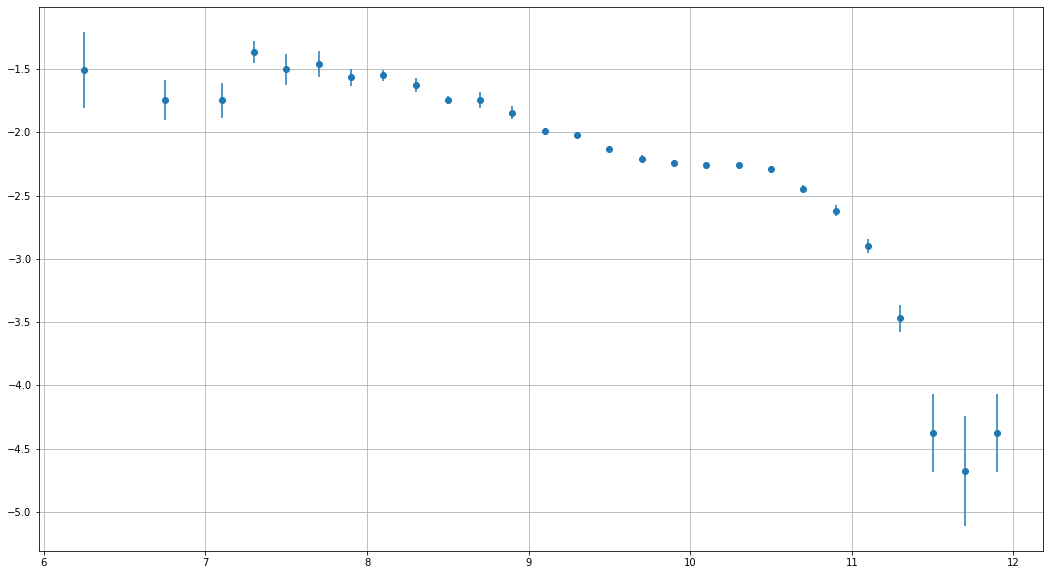

In [ ]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot(111)


ax.errorbar(x_baldry, np.log10(y_baldry*10**(-3)), yerr=yerr_baldry*np.log10(np.e)/y_baldry, fmt='o')
plt.grid()
plt.show()

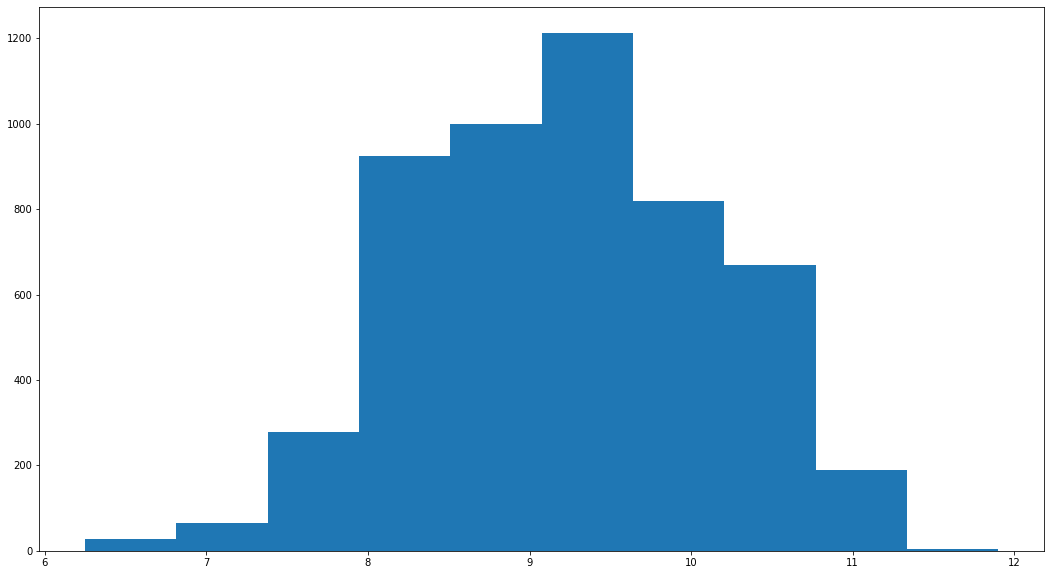

In [ ]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot(111)
ax.hist(x_baldry, weights=count_baldry)
plt.show()

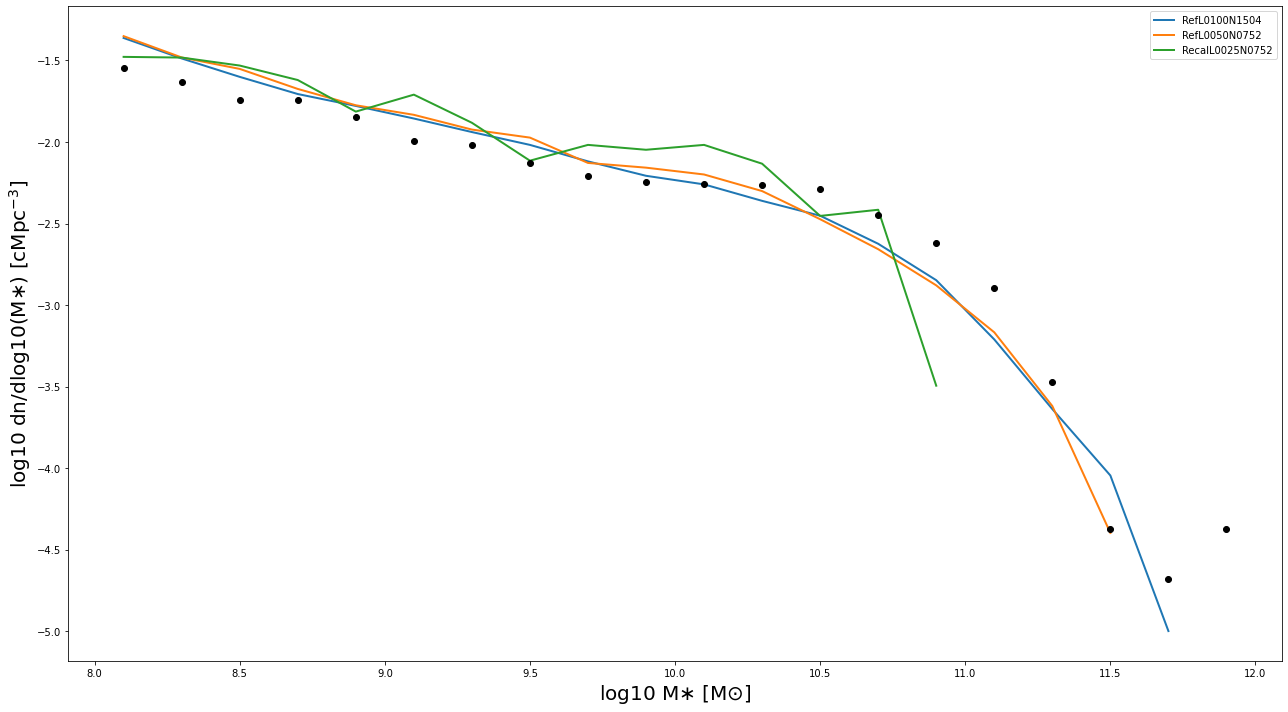

In [ ]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot(111)

mySims = np.array([('RefL0100N1504', 100.), ('RefL0050N0752', 50.), ('RecalL0025N0752', 25.)])
for sim_name, sim_size in mySims:

  myQuery = "SELECT \
                  0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 AS mass, \
                  count(*) AS num \
            FROM \
                  %s_SubHalo AS SH, \
                  %s_Aperture AS AP \
            WHERE \
                  SH.GalaxyID = AP.GalaxyID AND \
                  AP.Mass_Star >= 1E08 AND \
                  AP.ApertureSize = 30 AND \
                  SH.SnapNum = 27  \
            GROUP BY \
                  0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 \
            ORDER BY \
                  mass"%(sim_name, sim_name)                  


  myData = eagle.execute_query(con, myQuery)
  # Normalize by volume and bin width.
  hist = myData['num'][:] / float(sim_size)**3.
  hist = hist / 0.2
  ax.plot(myData['mass'], np.log10(hist), label=sim_name , linewidth=2)

ax.plot(x_baldry[x_baldry >= 8], np.log10(y_baldry*1e-3)[x_baldry >= 8], 'ko')

# Label plot.
ax.set_xlabel(r'log$ {10}$ M$ {∗}$ [M$ {\odot}$]', fontsize=20) 
ax.set_ylabel(r'log$ {10}$ dn/dlog$ {10}$(M$ {∗}$) [cMpc$^{−3}$]', fontsize=20) 
plt.tight_layout()
plt.legend()
plt.show()
 

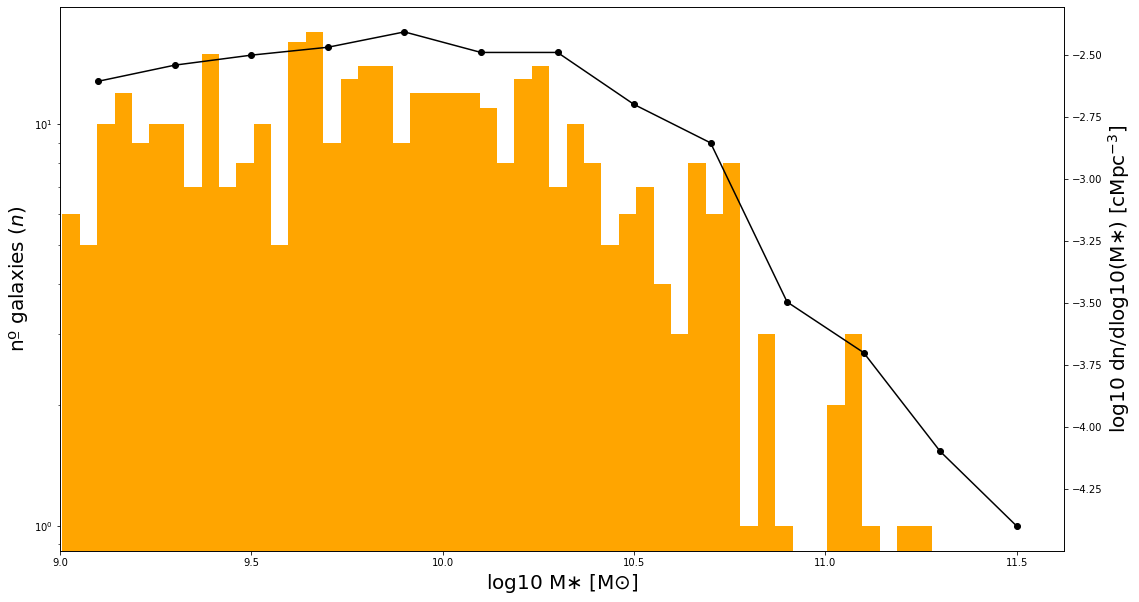

In [ ]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot(111)
ax_2 = ax.twinx()

sim_name = 'RefL0050N0752'
sim_size = '50'

myQuery = "SELECT \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 AS mass, \
                count(*) AS num \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E09 AND \
                SH.SnapNum = 27 AND \
                MK.KappaCoRot >= 0.4 \
          GROUP BY \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 \
          ORDER BY \
                mass"%(sim_name, sim_name)                  


myData = eagle.execute_query(con, myQuery)
# Normalize by volume and bin width.
hist = myData['num'][:] / float(sim_size)**3.
hist = hist / 0.2


# Data
ax.hist(np.log10(df_hist_m_stars_disc['Mass_stars']), bins=50, color='orange')
ax.set_yscale('log')

ax_2.plot(myData['mass'], np.log10(hist), 'k-o', label=sim_name )

# Label plot.
ax.set_xlabel(r'log$ {10}$ M$ {∗}$ [M$ {\odot}$]', fontsize=20) 
ax.set_ylabel(r'nº galaxies $(n)$', fontsize=20)
ax_2.set_ylabel(r'log$ {10}$ dn/dlog$ {10}$(M$ {∗}$) [cMpc$^{−3}$]', fontsize=20) 
ax.set_xlim(9)
plt.show()

In [ ]:
value_1, value_2 = numbers(df_hist_m_stars_disc['Mass_stars'])

for j in range(len(value_1)):
  print(myData['mass'][j], myData['num'][j], value_1[j])

9.1 62 35.0
9.3 72 41.0
9.5 79 38.0
9.700000000000001 85 63.0
9.9 98 52.0
10.1 81 44.0
10.3 81 50.0
10.5 50 25.0
10.700000000000001 35 25.0
10.9 8 4.0
11.1 5 6.0
11.3 2 2.0


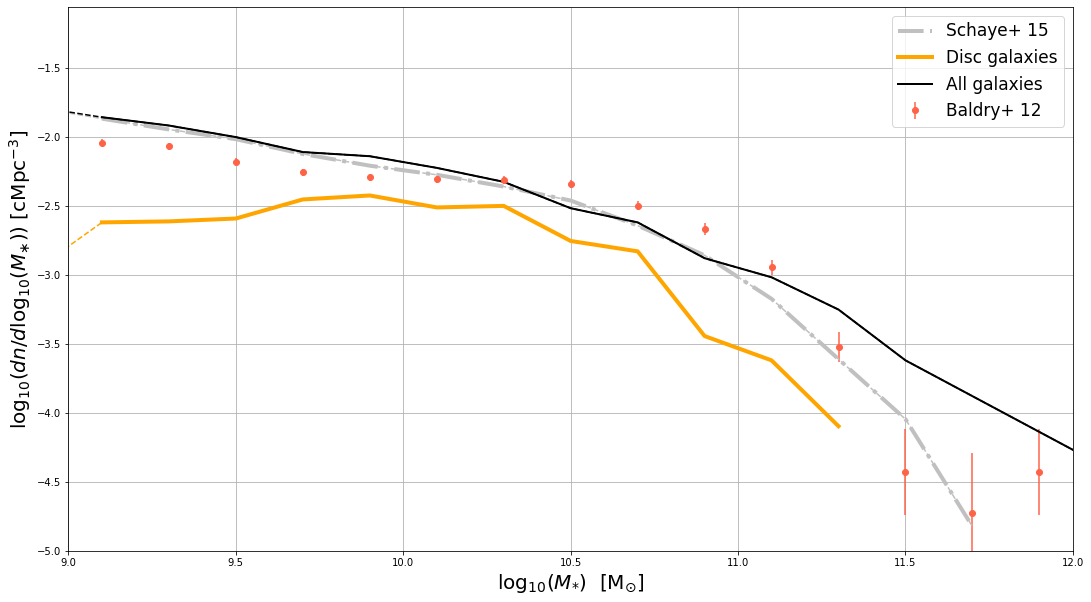

In [ ]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

sim_name = 'RefL0100N1504'
sim_size = '100'
myQuery = "SELECT \
                  0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 AS mass, \
                  count(*) AS num \
            FROM \
                  %s_SubHalo AS SH, \
                  %s_Aperture AS AP \
            WHERE \
                  SH.GalaxyID = AP.GalaxyID AND \
                  AP.Mass_Star >= 1E08 AND \
                  AP.ApertureSize = 30 AND \
                  SH.SnapNum = 28  \
            GROUP BY \
                  0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 \
            ORDER BY \
                  mass"%(sim_name, sim_name)                 


myData = eagle.execute_query(con, myQuery)
hist = myData['num'][:] / float(sim_size)**3.
hist = hist / 0.2
ax.plot(myData['mass'][myData['mass']>9], np.log10(hist)[myData['mass']>9], '-.',
        label='Schaye+ 15', linewidth=4, color = 'silver')
ax.plot(myData['mass'], np.log10(hist), '--', color='silver')

sim_name = 'RefL0050N0752'
sim_size = '50'

myQuery = "SELECT \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 AS mass, \
                count(*) AS num \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E06 AND \
                SH.SnapNum = 28 AND \
                MK.KappaCoRot >= 0.4 \
          GROUP BY \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 \
          ORDER BY \
                mass"%(sim_name, sim_name)                  


myData = eagle.execute_query(con, myQuery)
hist = myData['num'][:] / float(sim_size)**3.
hist = hist / 0.2
ax.plot(myData['mass'][myData['mass']>9], np.log10(hist)[myData['mass']>9], '-', color = 'orange', label='Disc galaxies', linewidth=4)
ax.plot(myData['mass'], np.log10(hist), '--', color= 'orange')

myQuery2 = "SELECT \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 AS mass, \
                count(*) AS num \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E06 AND \
                SH.SnapNum = 28 \
          GROUP BY \
                0.1+floor(log10(SH.MassType_Star)/0.2)*0.2 \
          ORDER BY \
                mass"%(sim_name, sim_name)

myData2 = eagle.execute_query(con, myQuery2)
hist2 = myData2['num'][:] / float(sim_size)**3.
hist2 = hist2 / 0.2
ax.plot(myData2['mass'][myData2['mass']>9], np.log10(hist2)[myData2['mass']>9], 'k-', label='All galaxies', linewidth=2)
ax.plot(myData2['mass'], np.log10(hist2), 'k--')


ax.errorbar(x_baldry, np.log10(y_baldry*10**(-3))-0.05, yerr=yerr_baldry*np.log10(np.e)/y_baldry, fmt='o', label='Baldry+ 12', color='tomato')


ax.set_xlabel(r'$\log_{10}(M_{*})$  $\left[\mathrm{M}_{\odot}\right]$', fontsize=20) 
ax.set_ylabel(r'$\log_{10}\left(dn/d\log_{10}(M_{∗})\right)$ [$\mathrm{cMpc}^{−3}$]', fontsize=20) 
ax.set_xlim(9, 12)
ax.set_ylim(-5)
ax.grid()
ax.legend(fontsize=17)
plt.show()

# Comparaciones entre GSMF

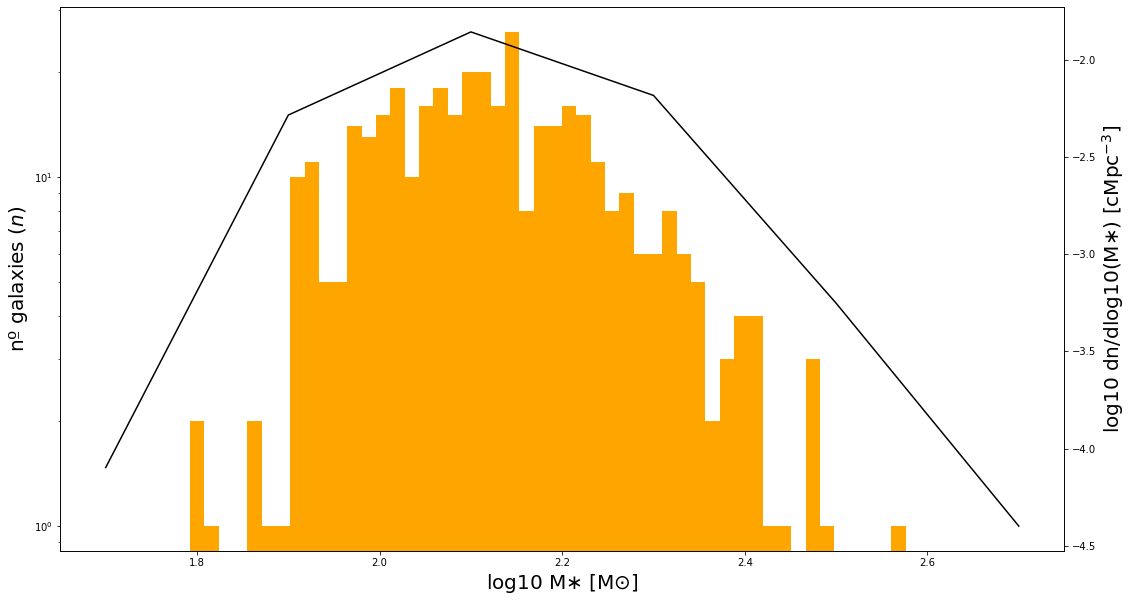

In [ ]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot(111)
ax_2 = ax.twinx()

sim_name = 'RefL0050N0752'
sim_size = '50'

myQuery = "SELECT \
                0.1+floor(log10(SH.Vmax)/0.2)*0.2 AS mass, \
                count(*) AS num \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E09 AND \
                SH.SnapNum = 27 AND \
                MK.KappaCoRot >= 0.4 \
          GROUP BY \
                0.1+floor(log10(SH.Vmax)/0.2)*0.2 \
          ORDER BY \
                mass"%(sim_name, sim_name)                  


myData = eagle.execute_query(con, myQuery)
# Normalize by volume and bin width.
hist = myData['num'][:] / float(sim_size)**3.
hist = hist / 0.2

# Data
ax.hist(np.log10(df_hist_v_max_disc['v_max']), bins=50, color='orange')
ax.set_yscale('log')

ax_2.plot(myData['mass'], np.log10(hist), 'k-', label=sim_name )

# Label plot.
ax.set_xlabel(r'log$ {10}$ M$ {∗}$ [M$ {\odot}$]', fontsize=20) 
ax.set_ylabel(r'nº galaxies $(n)$', fontsize=20)
ax_2.set_ylabel(r'log$ {10}$ dn/dlog$ {10}$(M$ {∗}$) [cMpc$^{−3}$]', fontsize=20) 
plt.show()